In [1]:
import torch
import mx
from mx.mx_ops import quantize_mx_op, get_mx_quantize_params, apply_mx_quantize_with_param
from mx.elemwise_ops import quantize_elemwise_op
from mx.specs import MxSpecs

hadamard_utils is not imported


In [2]:
past_key_value = torch.load("/home/shaoyuantian/program/MXFP4-LLM/sorting_index/Meta-Llama-3-8B-layer0-past_key_value.pt",
                            map_location="cuda:0", weights_only=False)

/home/shaoyuantian/anaconda3/envs/mx-qllm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
key = past_key_value.key_cache[0].transpose(1, 2).reshape(1, 2048, -1).squeeze()
value = past_key_value.value_cache[0].transpose(1, 2).reshape(1, 2048, -1).squeeze()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_3d_matrix(matrix,
                   title='3D Surface Plot',
                   xlabel='Channel',
                   ylabel='Token',
                   zlabel='Intensity',
                   cmap='coolwarm'):
    """
    将输入的矩阵进行 3D 可视化。

    参数:
    matrix: 2D numpy 数组 或 torch.Tensor，表示要可视化的矩阵
    xlabel: X 轴的标签
    ylabel: Y 轴的标签
    zlabel: Z 轴的标签
    cmap: 颜色映射，默认 'coolwarm'
    """
    # 如果输入是 torch.Tensor，转换为 numpy.ndarray
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.numpy()

    # 确保输入是二维矩阵
    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        raise ValueError("输入必须是一个二维矩阵（numpy array 或 torch tensor）。")

    M, N = matrix.shape
    X = np.arange(N)
    Y = np.arange(M)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制 3D 表面图
    ax.plot_surface(X, Y, matrix, cmap=cmap)

    # 设置坐标轴标签
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.title.set_text(title)

    plt.show()


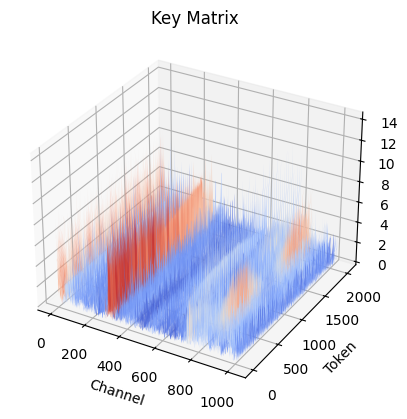

In [5]:
plot_3d_matrix(key.abs().cpu().float(), title='Key Matrix', xlabel='Channel', ylabel='Token', zlabel='Intensity')

In [6]:
query = torch.load("/home/shaoyuantian/program/MXFP4-LLM/sorting_index/Meta-Llama-3-8B-q_states.pt",
                   map_location="cuda:0", weights_only=False)

In [7]:
query0 = query['layer_0_act_avg'].squeeze()

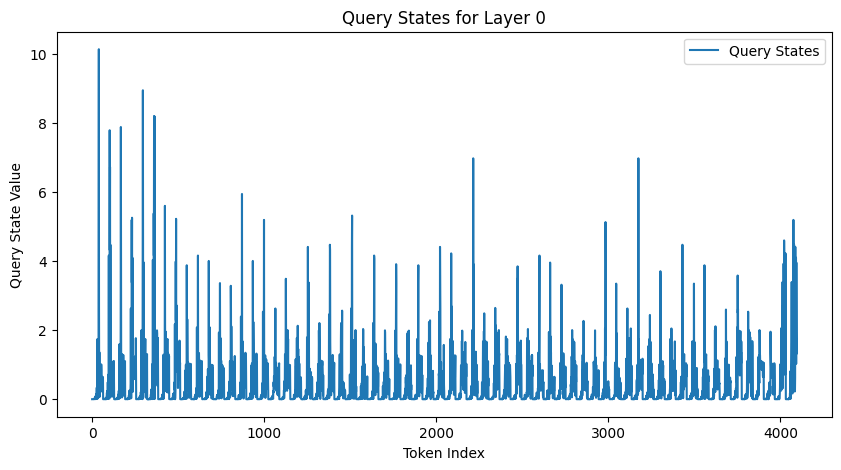

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(query0.cpu().float().abs().numpy(), label='Query States')
plt.title('Query States for Layer 0')
plt.xlabel('Token Index')
plt.ylabel('Query State Value')
plt.legend()
plt.show()

/tmp/ipykernel_147930/3383373545.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


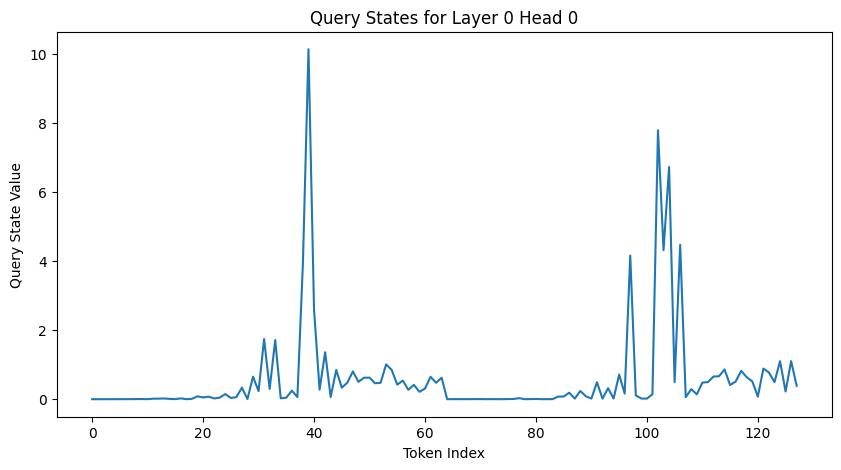

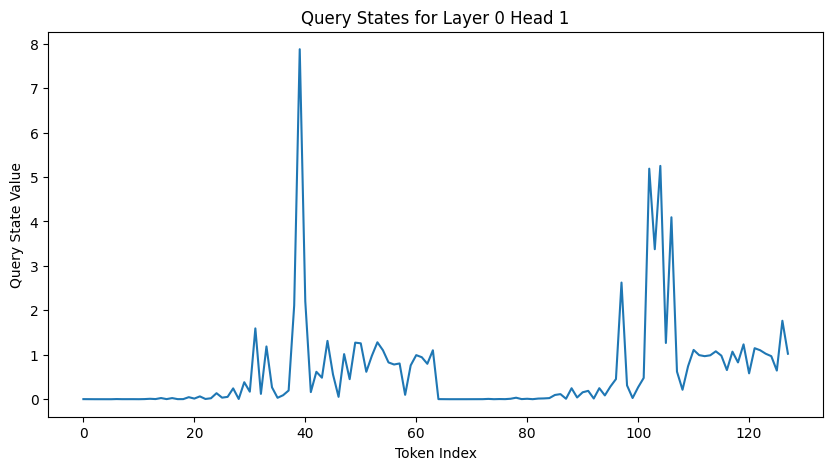

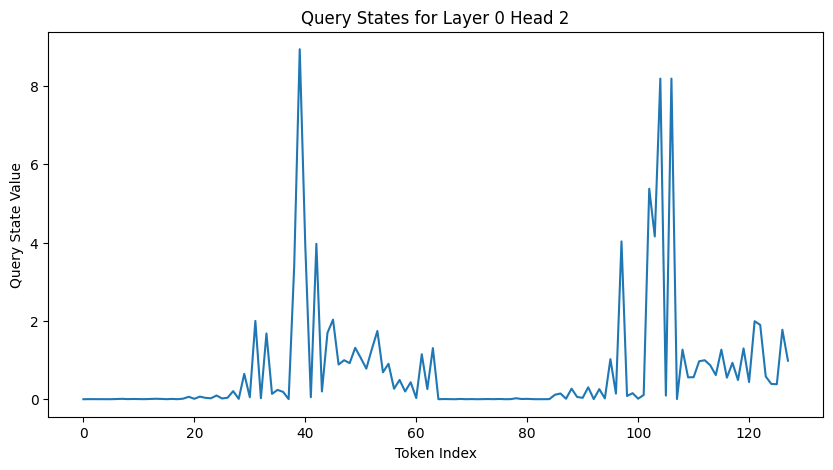

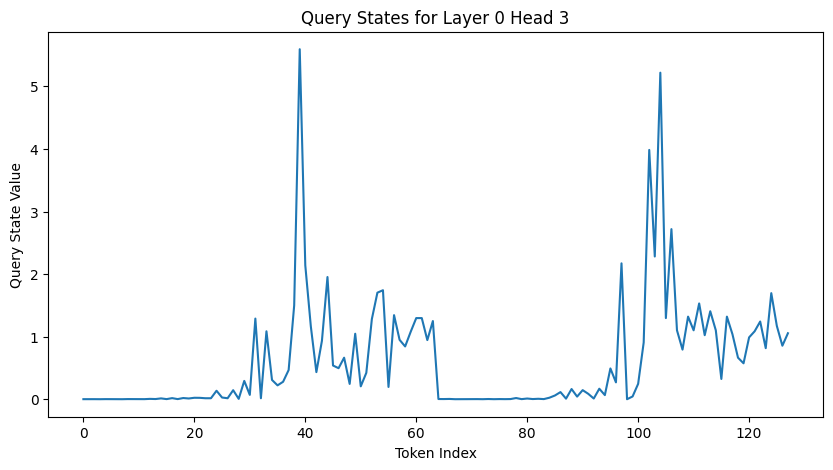

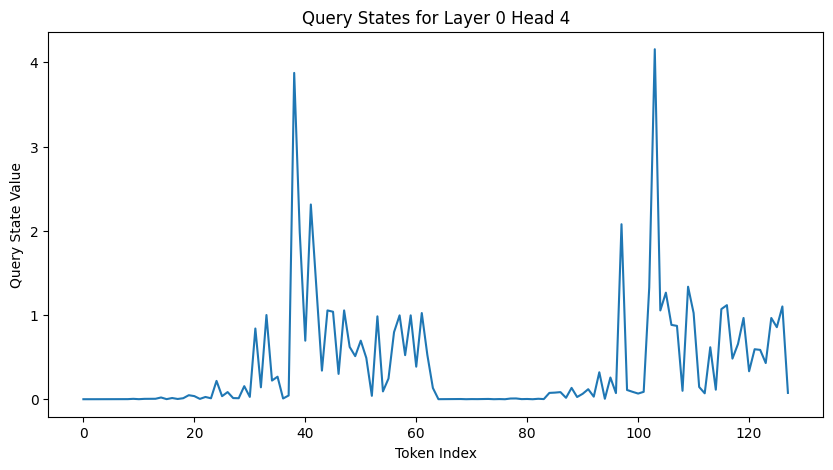

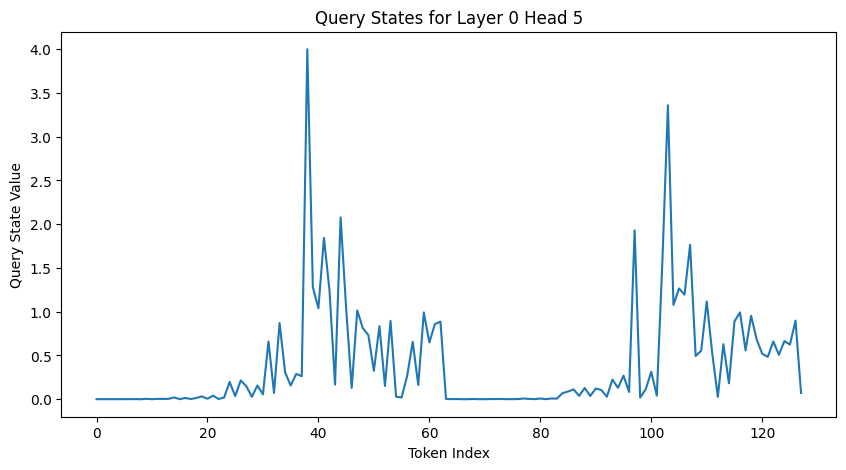

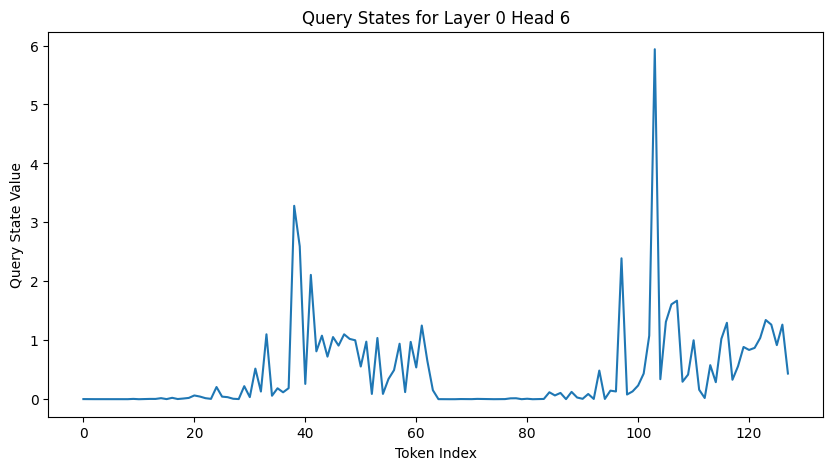

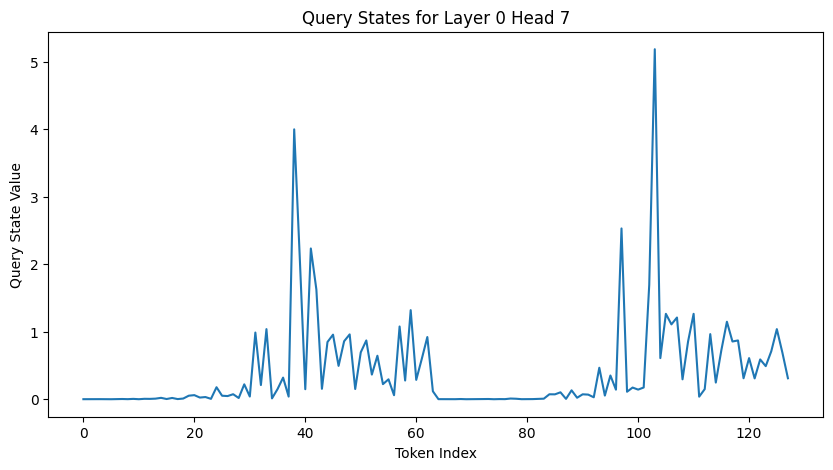

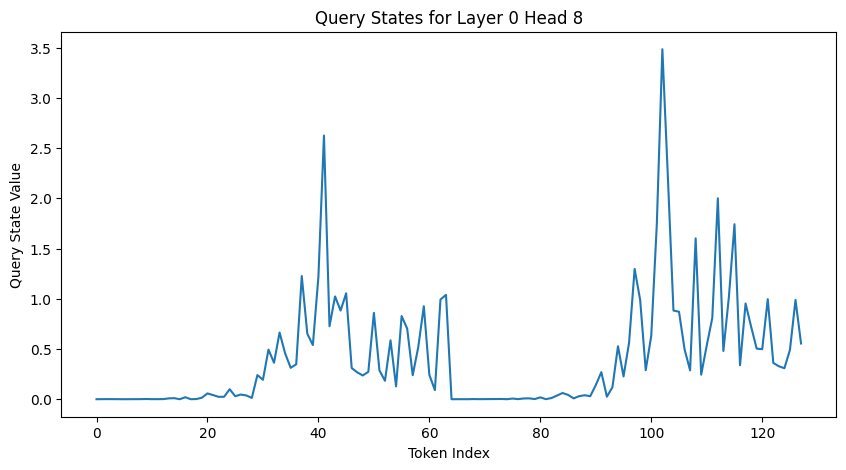

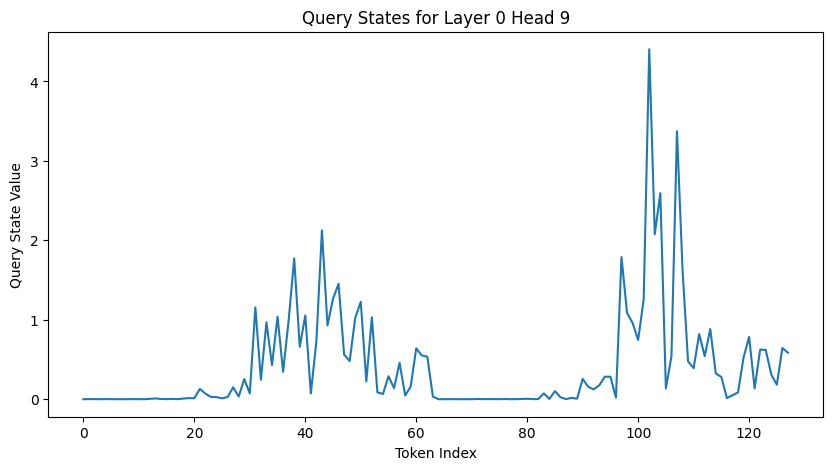

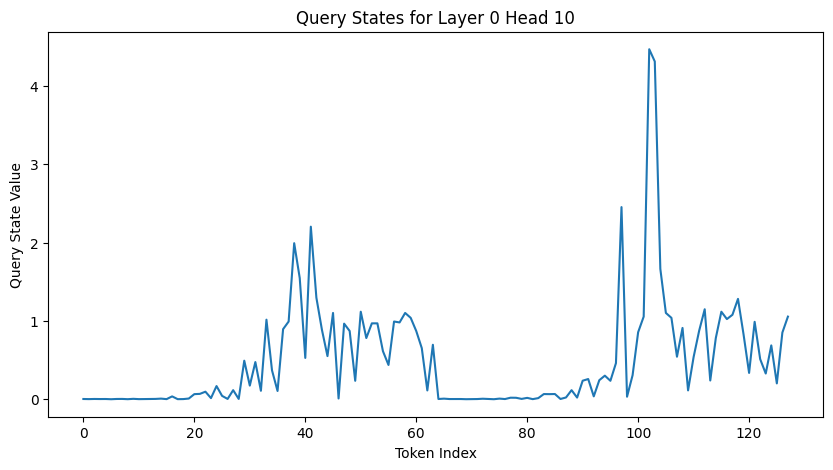

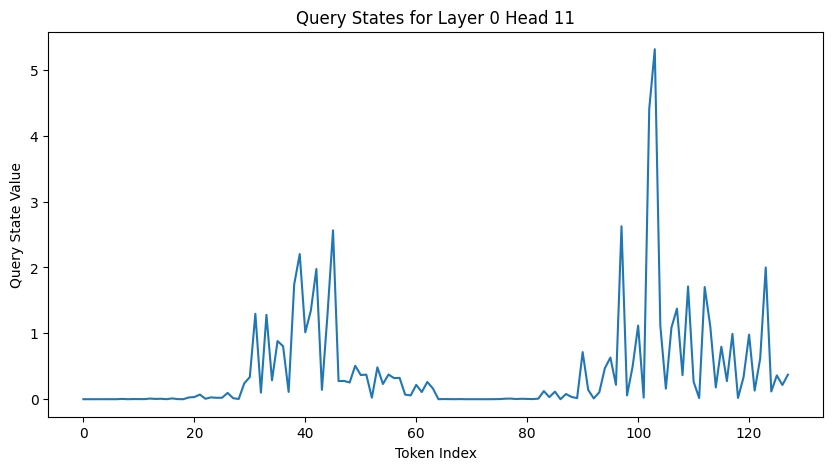

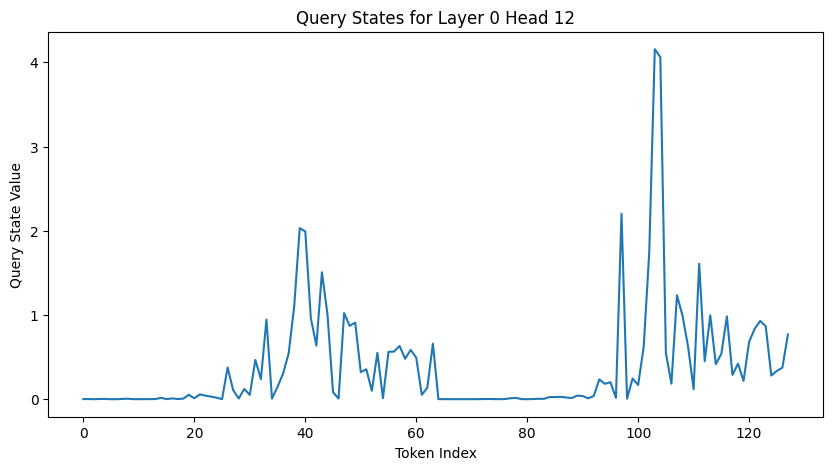

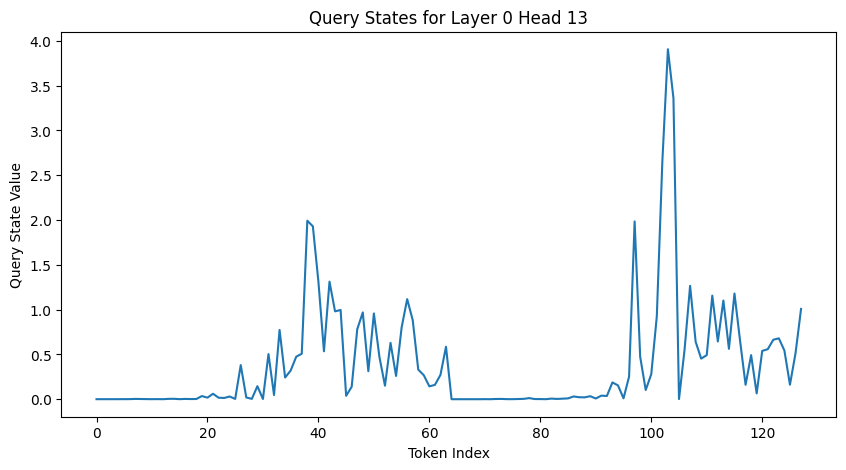

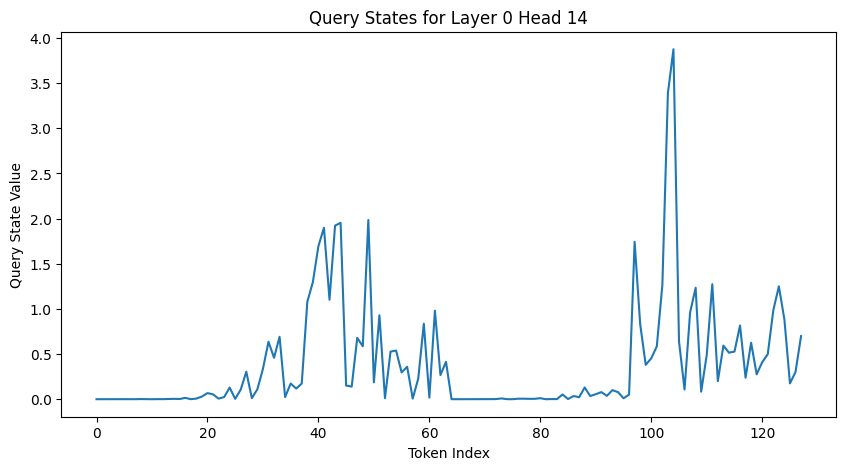

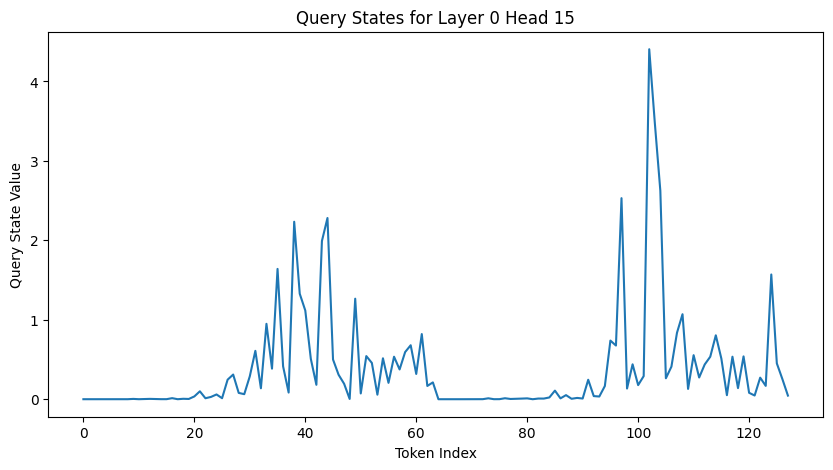

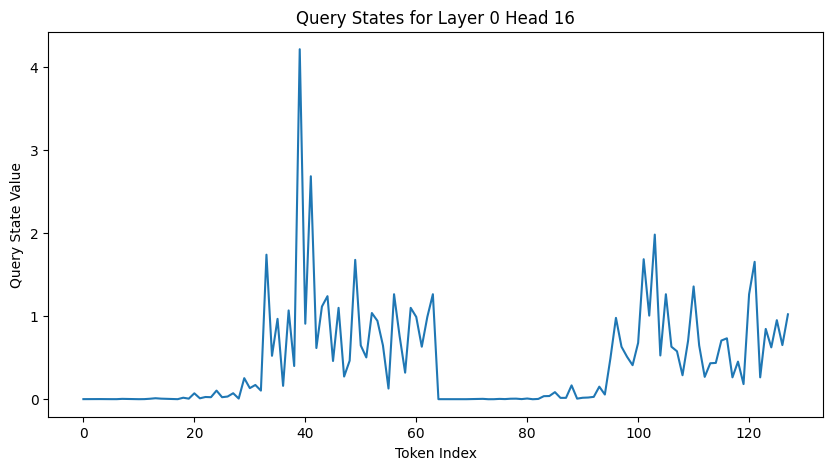

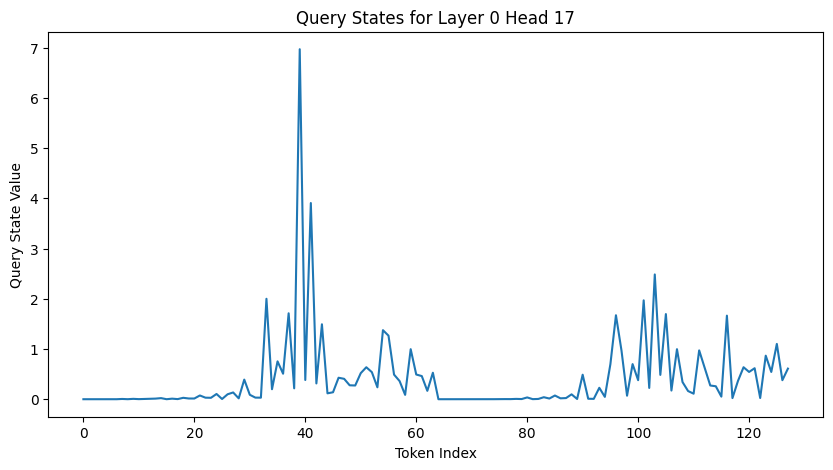

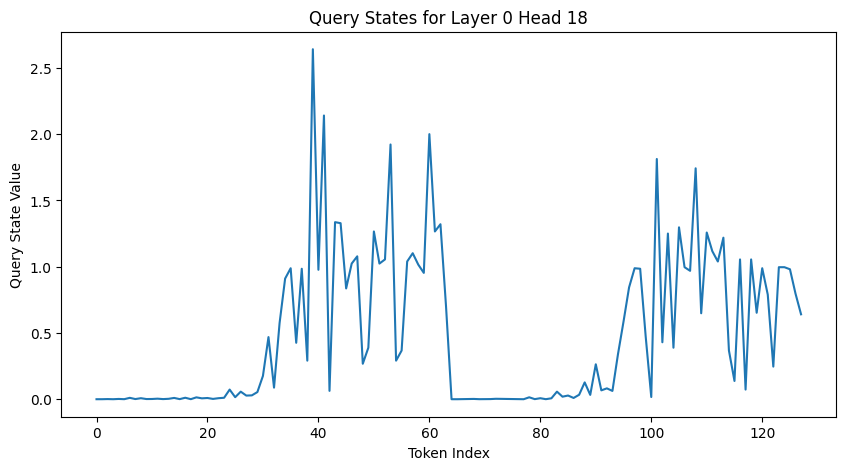

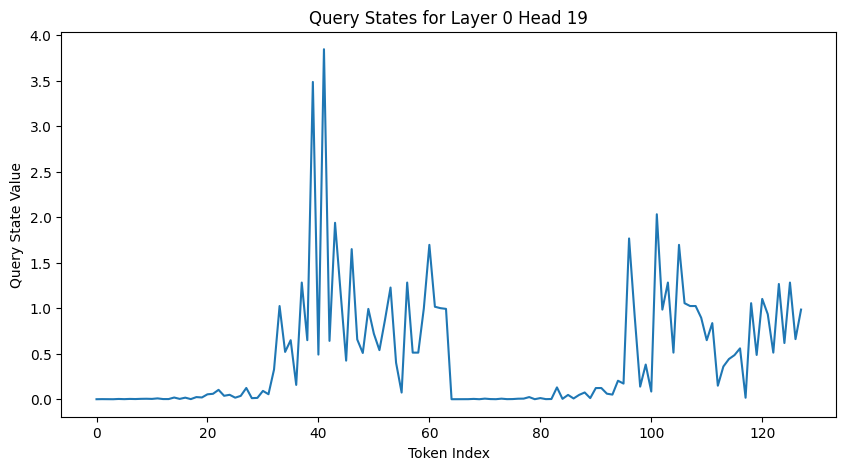

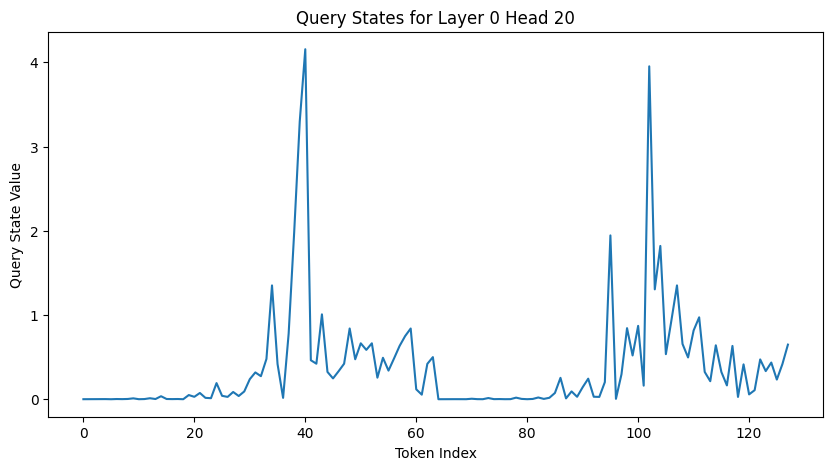

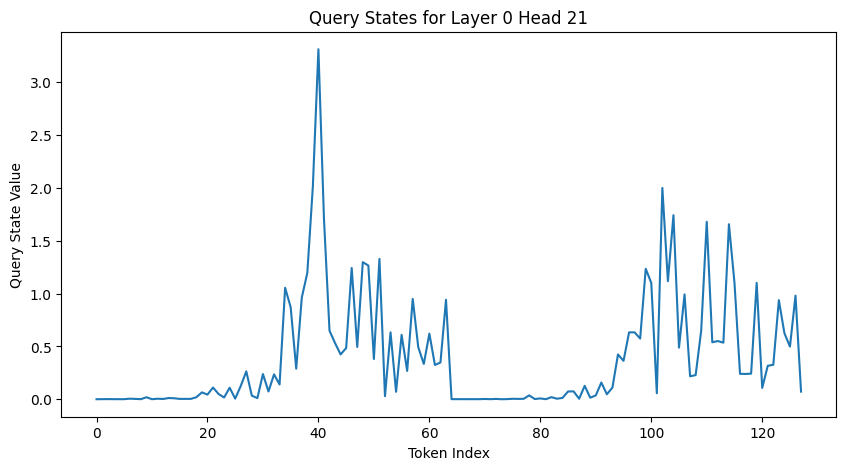

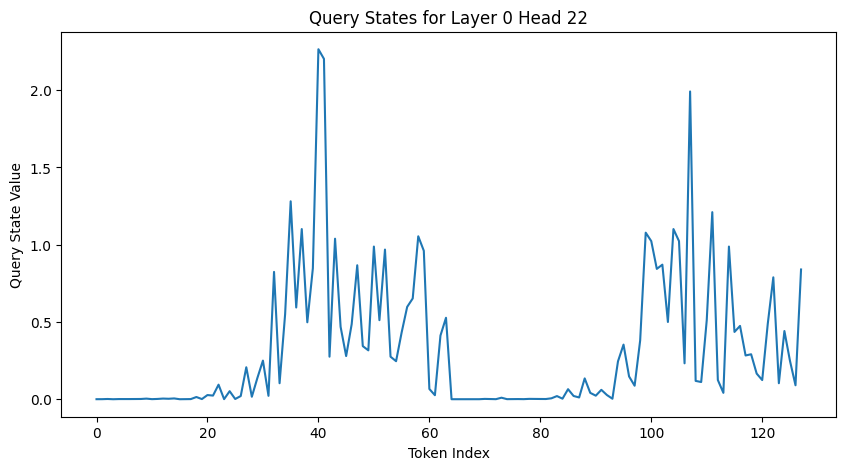

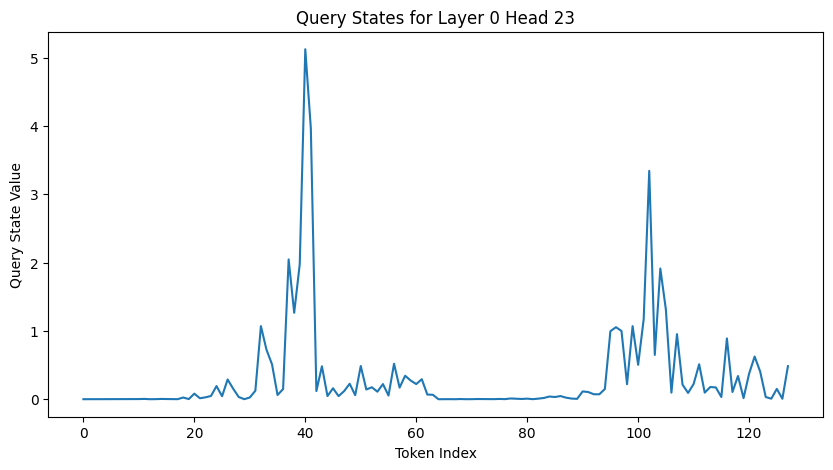

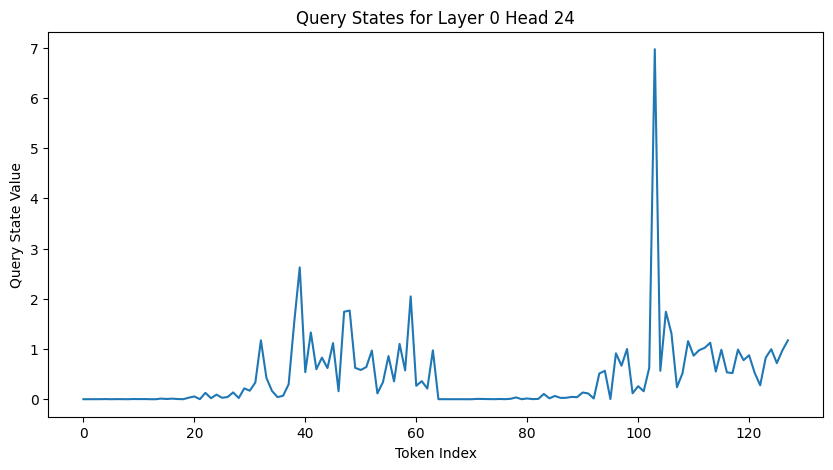

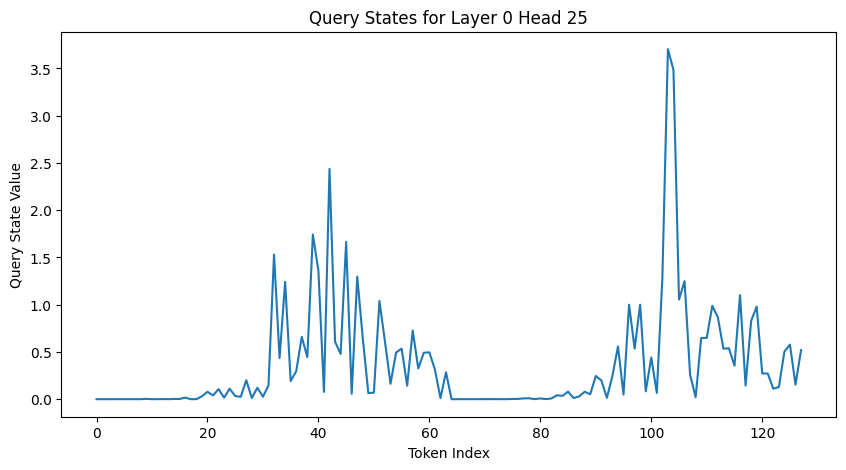

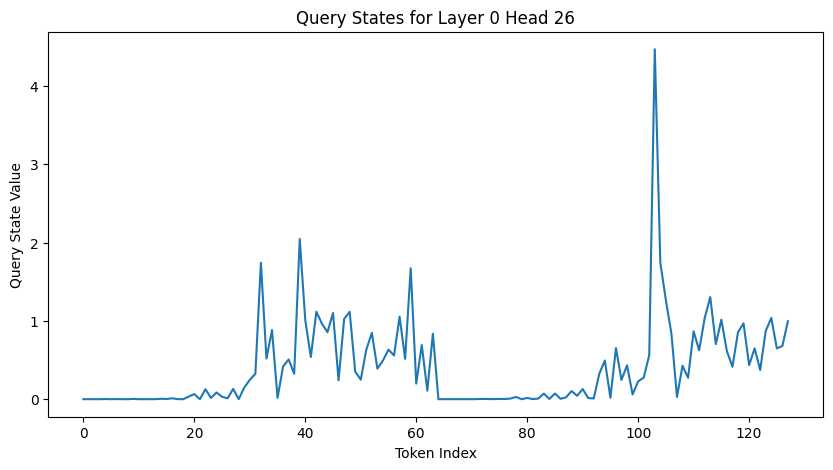

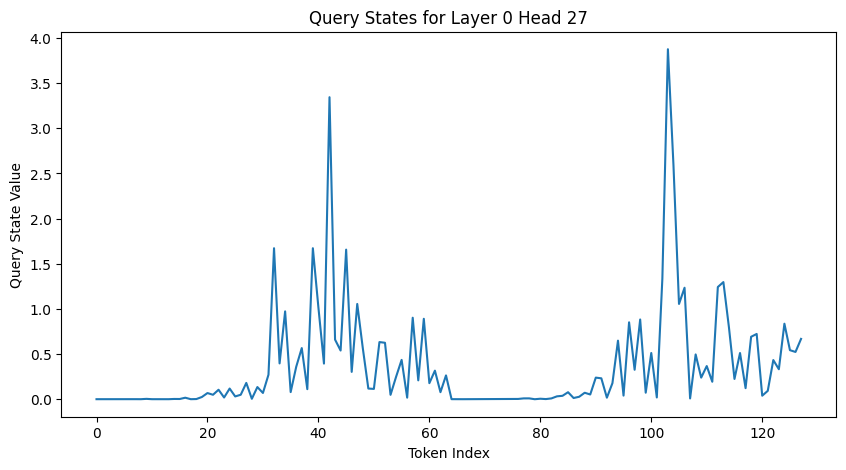

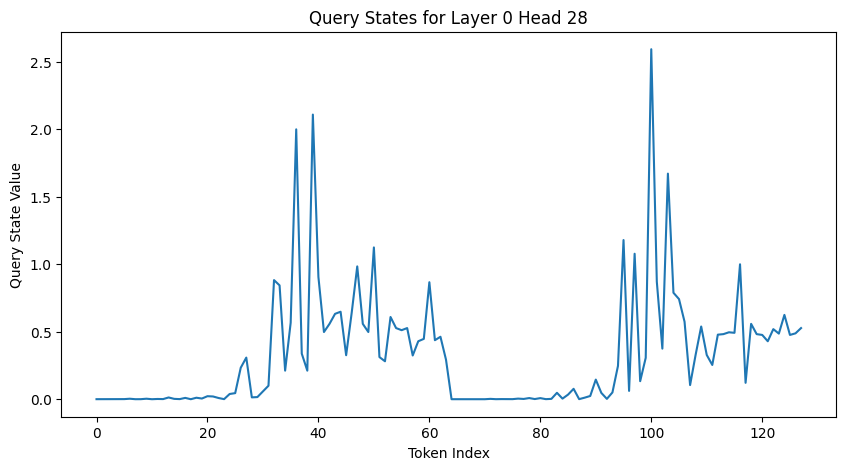

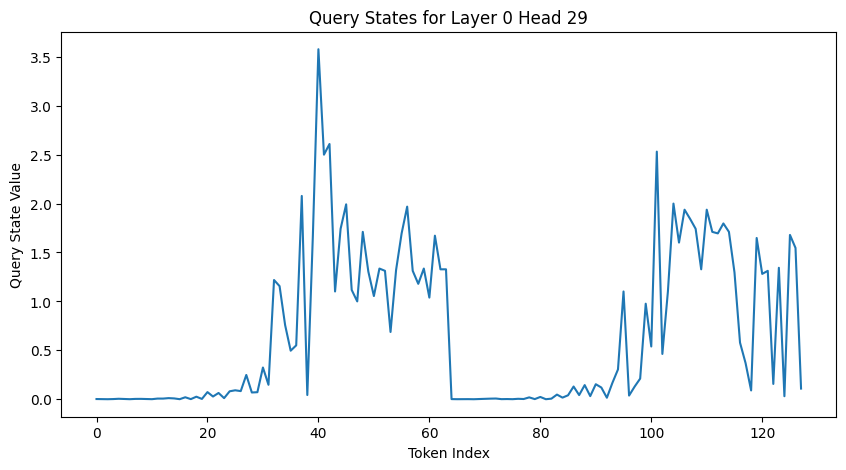

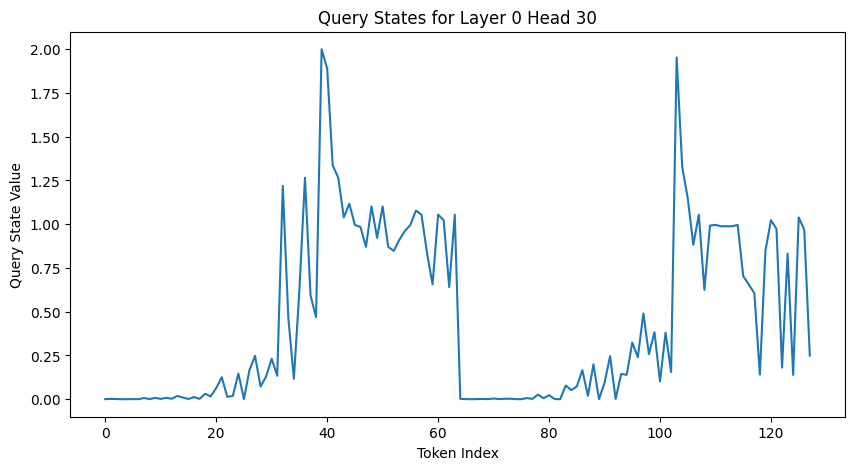

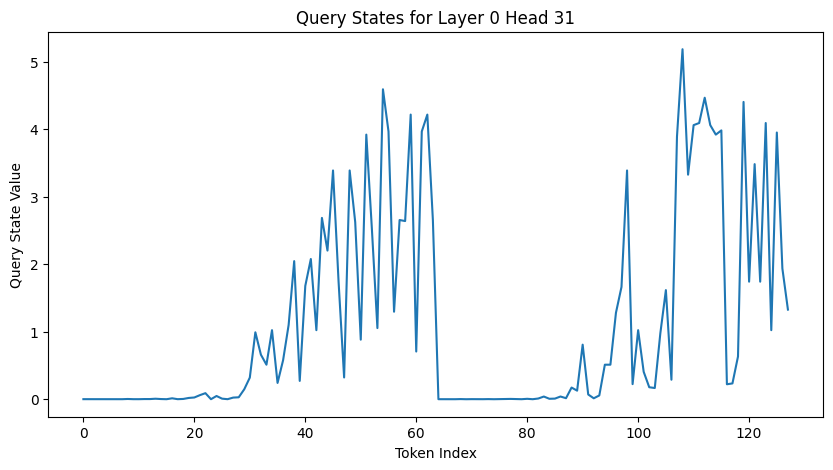

In [9]:
import matplotlib.pyplot as plt
y = query0.cpu().float().abs().numpy()
for i in range(0, query0.shape[0], 128):
    plt.figure(figsize=(10, 5))
    x = np.arange(128)
    plt.plot(x, y[i:i+128], label=f'Head {i //128}')
    plt.title(f'Query States for Layer 0 Head {i //128}')
    plt.xlabel('Token Index')
    plt.ylabel('Query State Value')

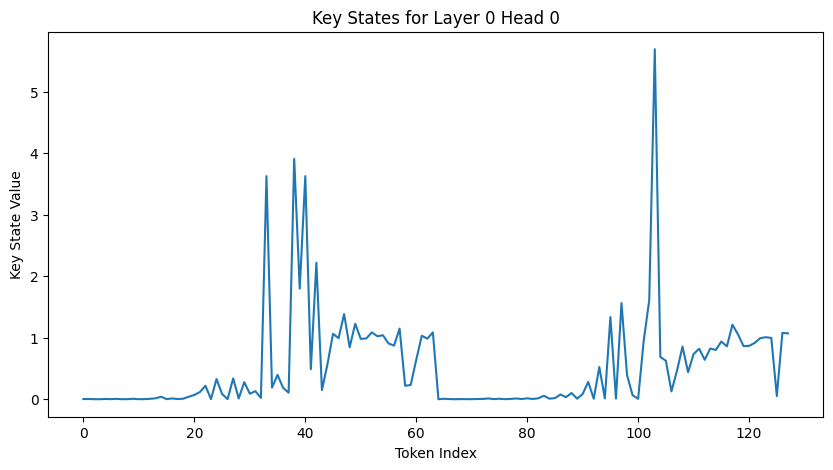

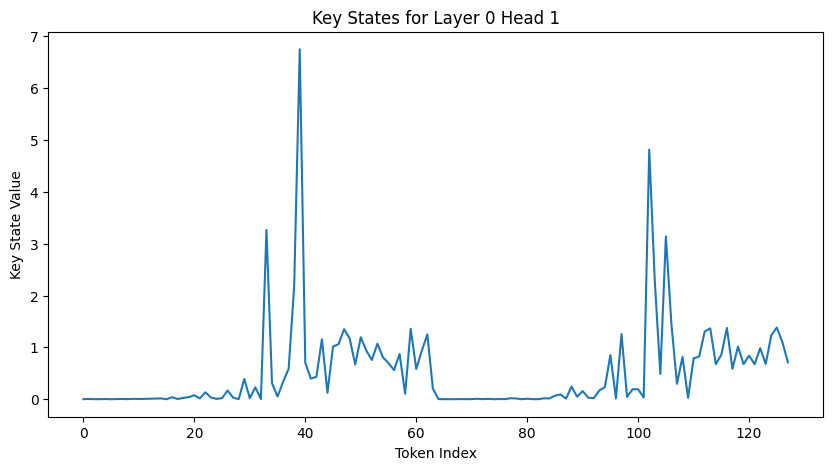

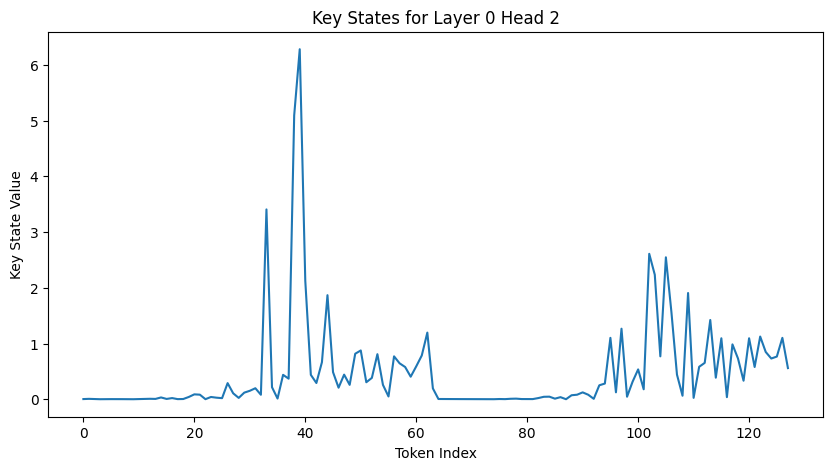

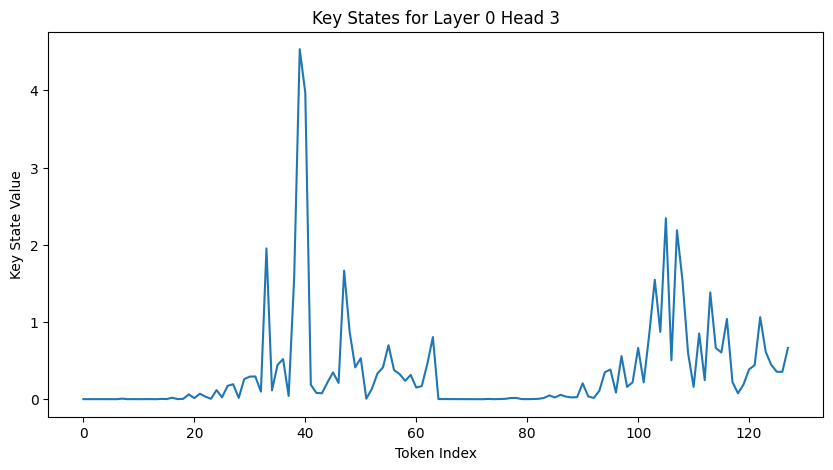

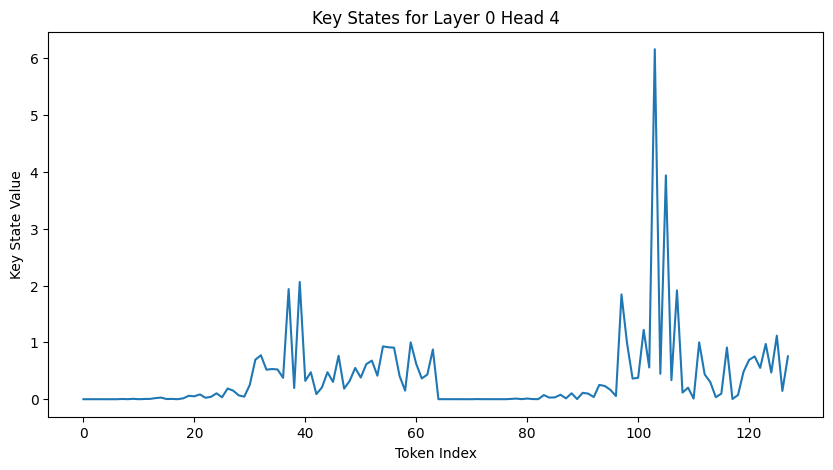

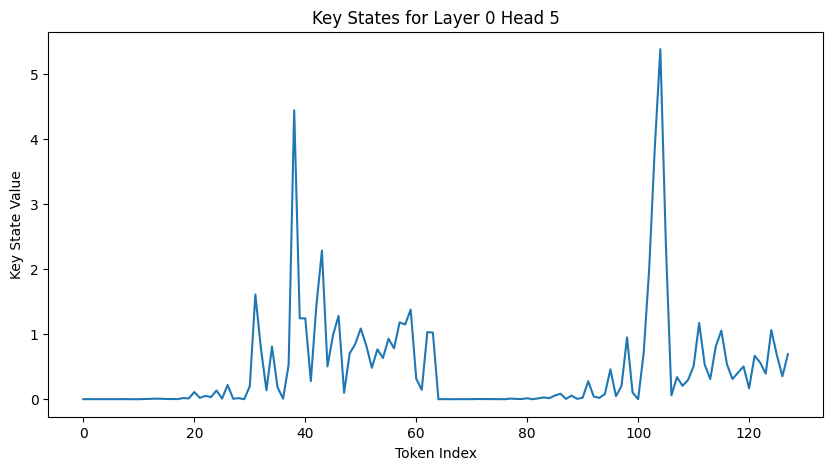

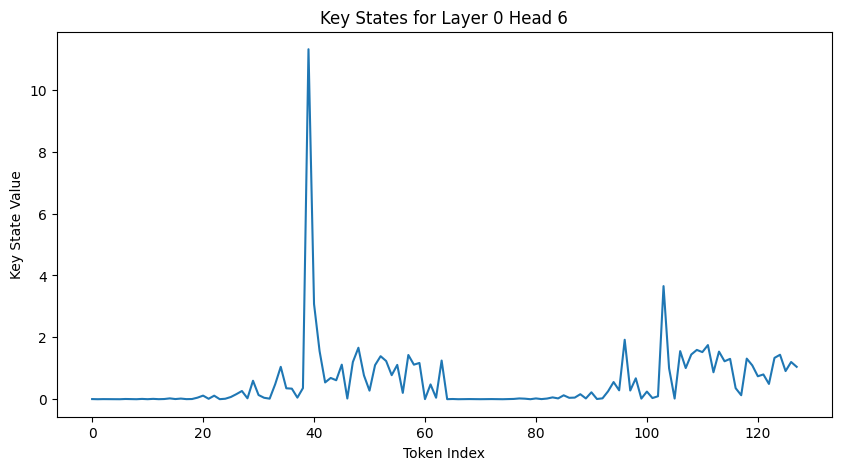

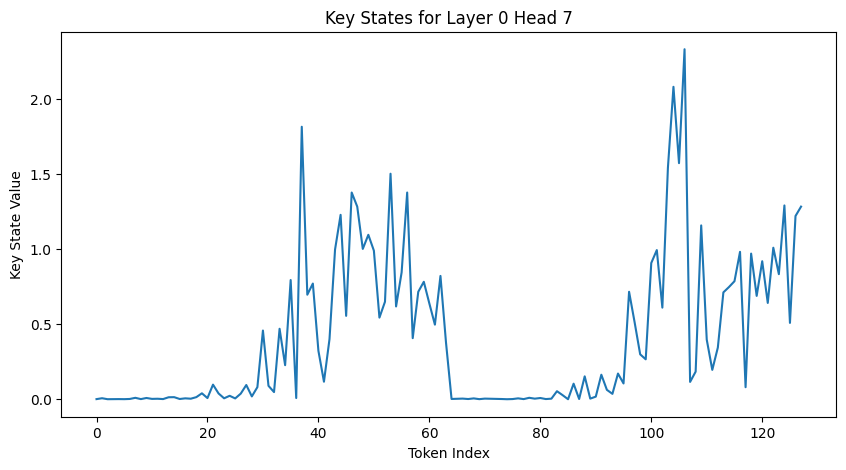

In [10]:
key = torch.load("/home/shaoyuantian/program/MXFP4-LLM/sorting_index/Meta-Llama-3-8B-k_states.pt",
                 map_location="cuda:0", weights_only=False)
key0 = key['layer_0_act_avg'].squeeze()
y = key0.cpu().float().abs().numpy()
for i in range(0, key0.shape[0], 128):
    plt.figure(figsize=(10, 5))
    x = np.arange(128)
    plt.plot(x, y[i:i+128], label=f'Head {i //128}')
    plt.title(f'Key States for Layer 0 Head {i //128}')
    plt.xlabel('Token Index')
    plt.ylabel('Key State Value')

In [11]:
mx_specs = MxSpecs()
mx_specs["custom_cuda"] = True

In [12]:
query0 = quantize_elemwise_op(
            query0.float(), mx_specs=mx_specs, round=mx_specs["round_output"]
        )
key0 = quantize_elemwise_op(
            key0.float(), mx_specs=mx_specs, round=mx_specs["round_output"]
        )

In [13]:
q_query0 = quantize_mx_op(query0,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
q_key0 = quantize_mx_op(key0,
                        mx_specs,
                        elem_format="fp4_e2m1",
                        block_size=32,
                        axes=-1,
                        scale_mode=0,)

/home/shaoyuantian/anaconda3/envs/mx-qllm/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [14]:
def compute_tile_quantization_loss(original, quantized, block_size=32, loss_type='mse'):
    """
    计算每个 tile 的量化损失
    
    Args:
        original: 原始张量
        quantized: 量化后的张量
        block_size: tile 大小
        loss_type: 损失类型 ('mse', 'mae', 'cosine')
    """
    
    # 确保张量形状一致
    assert original.shape == quantized.shape
    
    # 计算需要 padding 的长度
    seq_len = original.shape[-1]
    num_tiles = (seq_len + block_size - 1) // block_size
    padded_len = num_tiles * block_size
    
    # Padding 到完整的 tile
    if padded_len > seq_len:
        padding = padded_len - seq_len
        original_padded = torch.nn.functional.pad(original, (0, padding))
        quantized_padded = torch.nn.functional.pad(quantized, (0, padding))
    else:
        original_padded = original
        quantized_padded = quantized
    
    # 重塑为 tiles
    original_tiles = original_padded.view(-1, block_size)  # [num_tiles, block_size]
    quantized_tiles = quantized_padded.view(-1, block_size)
    
    # 计算每个 tile 的损失
    if loss_type == 'mse':
        tile_losses = torch.mean((original_tiles - quantized_tiles) ** 2, dim=1)
    elif loss_type == 'mae':
        tile_losses = torch.mean(torch.abs(original_tiles - quantized_tiles), dim=1)
    elif loss_type == 'cosine':
        # 余弦相似度损失 (1 - cosine_similarity)
        cosine_sim = torch.nn.functional.cosine_similarity(original_tiles, quantized_tiles, dim=1)
        tile_losses = 1 - cosine_sim
    elif loss_type == 'snr':
        # 信噪比损失
        signal_power = torch.mean(original_tiles ** 2, dim=1)
        noise_power = torch.mean((original_tiles - quantized_tiles) ** 2, dim=1)
        tile_losses = -10 * torch.log10(signal_power / (noise_power + 1e-8))
    
    return tile_losses

In [15]:
q_query0_loss = compute_tile_quantization_loss(query0, q_query0, block_size=32, loss_type='mse')
q_key0_loss = compute_tile_quantization_loss(key0, q_key0, block_size=32, loss_type='mse')

In [16]:
from fast_hadamard_transform import hadamard_transform
import math
query0_roted = hadamard_transform(query0.reshape(-1, query0.shape[0] // 32,
                                                      32), scale=1 / math.sqrt(32)).reshape(-1)
key0_roted = hadamard_transform(key0.reshape(-1, key0.shape[0] // 32,
                                                      32), scale=1 / math.sqrt(32)).reshape(-1)

In [17]:
q_roted_query0 = quantize_mx_op(query0_roted,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
q_roted_key0 = quantize_mx_op(key0_roted,
                        mx_specs,
                        elem_format="fp4_e2m1",
                        block_size=32,
                        axes=-1,
                        scale_mode=0,)

In [18]:
q_roted_query0_loss = compute_tile_quantization_loss(query0_roted, q_roted_query0, block_size=32, loss_type='mse')
q_roted_key0_loss = compute_tile_quantization_loss(key0_roted, q_roted_key0, block_size=32, loss_type='mse')

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 增强版绘图函数 - 修复中文显示
def plot_detailed_quantization_analysis(q_t1_loss, q_t2_loss, q_t1_label='scale_mode=0', q_t2_label='scale_mode=2'):
    """
    绘制详细的量化损失分析图
    """
    
    # 转换为 numpy
    q_t1_np = q_t1_loss.cpu().numpy() if hasattr(q_t1_loss, 'cpu') else q_t1_loss
    q_t2_np = q_t2_loss.cpu().numpy() if hasattr(q_t2_loss, 'cpu') else q_t2_loss
    
    num_tiles = len(q_t1_np)
    tile_indices = np.arange(num_tiles)
    
    # 创建子图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 柱状图对比
    width = 0.35
    axes[0,0].bar(tile_indices - width/2, q_t1_np, width, 
                  label=q_t1_label, color='lightblue', alpha=0.8)
    axes[0,0].bar(tile_indices + width/2, q_t2_np, width, 
                  label=q_t2_label, color='darkblue', alpha=0.8)
    axes[0,0].set_xlabel('Group Index (Tile Index)')
    axes[0,0].set_ylabel('Quantization Loss (MSE)')
    axes[0,0].set_title('Quantization Loss Comparison')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 差值分析
    diff = q_t1_np - q_t2_np
    colors = ['green' if d > 0 else 'red' for d in diff]
    axes[0,1].bar(tile_indices, diff, color=colors, alpha=0.7)
    axes[0,1].set_xlabel('Group Index (Tile Index)')
    axes[0,1].set_ylabel('Loss Difference (q_t1 - q_t2)')
    axes[0,1].set_title('Loss Difference (Green: scale_mode=2 Better)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 3. 改进百分比
    improvement = (diff / q_t1_np) * 100
    axes[1,0].bar(tile_indices, improvement, color='orange', alpha=0.7)
    axes[1,0].set_xlabel('Group Index (Tile Index)')
    axes[1,0].set_ylabel('Improvement Percentage (%)')
    axes[1,0].set_title(f'{q_t1_label} vs {q_t2_label} Improvement')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 4. 累积损失
    cumsum_t1 = np.cumsum(q_t1_np)
    cumsum_t2 = np.cumsum(q_t2_np)
    axes[1,1].plot(tile_indices, cumsum_t1, 'o-', label=q_t1_label, 
                   color='lightblue', linewidth=2, markersize=4)
    axes[1,1].plot(tile_indices, cumsum_t2, 's-', label=q_t2_label, 
                   color='darkblue', linewidth=2, markersize=4)
    axes[1,1].set_xlabel('Group Index (Tile Index)')
    axes[1,1].set_ylabel('Cumulative Loss')
    axes[1,1].set_title('Cumulative Quantization Loss')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("=" * 60)
    print("Quantization Loss Statistical Analysis")
    print("=" * 60)
    print(f"{'Metric':<20} {q_t1_label:<15} {q_t2_label:<15} {'Improvement%':<10}")
    print("-" * 60)
    print(f"{'Average Loss':<20} {np.mean(q_t1_np):<15.6f} {np.mean(q_t2_np):<15.6f} {np.mean(improvement):<10.2f}")
    print(f"{'Total Loss':<20} {np.sum(q_t1_np):<15.6f} {np.sum(q_t2_np):<15.6f} {(np.sum(diff)/np.sum(q_t1_np)*100):<10.2f}")
    print(f"{'Max Loss':<20} {np.max(q_t1_np):<15.6f} {np.max(q_t2_np):<15.6f} {np.max(improvement):<10.2f}")
    print(f"{'Min Loss':<20} {np.min(q_t1_np):<15.6f} {np.min(q_t2_np):<15.6f} {np.min(improvement):<10.2f}")
    print(f"{'Std Dev':<20} {np.std(q_t1_np):<15.6f} {np.std(q_t2_np):<15.6f}")


In [20]:
total_roted_query0 = hadamard_transform(query0.reshape(-1, query0.shape[0] // 128,
                                                      128), scale=1 / math.sqrt(128)).reshape(-1)
q_total_roted_query0 = quantize_mx_op(total_roted_query0,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
q_total_roted_query0_loss = compute_tile_quantization_loss(total_roted_query0, q_total_roted_query0, block_size=32, loss_type='mse')

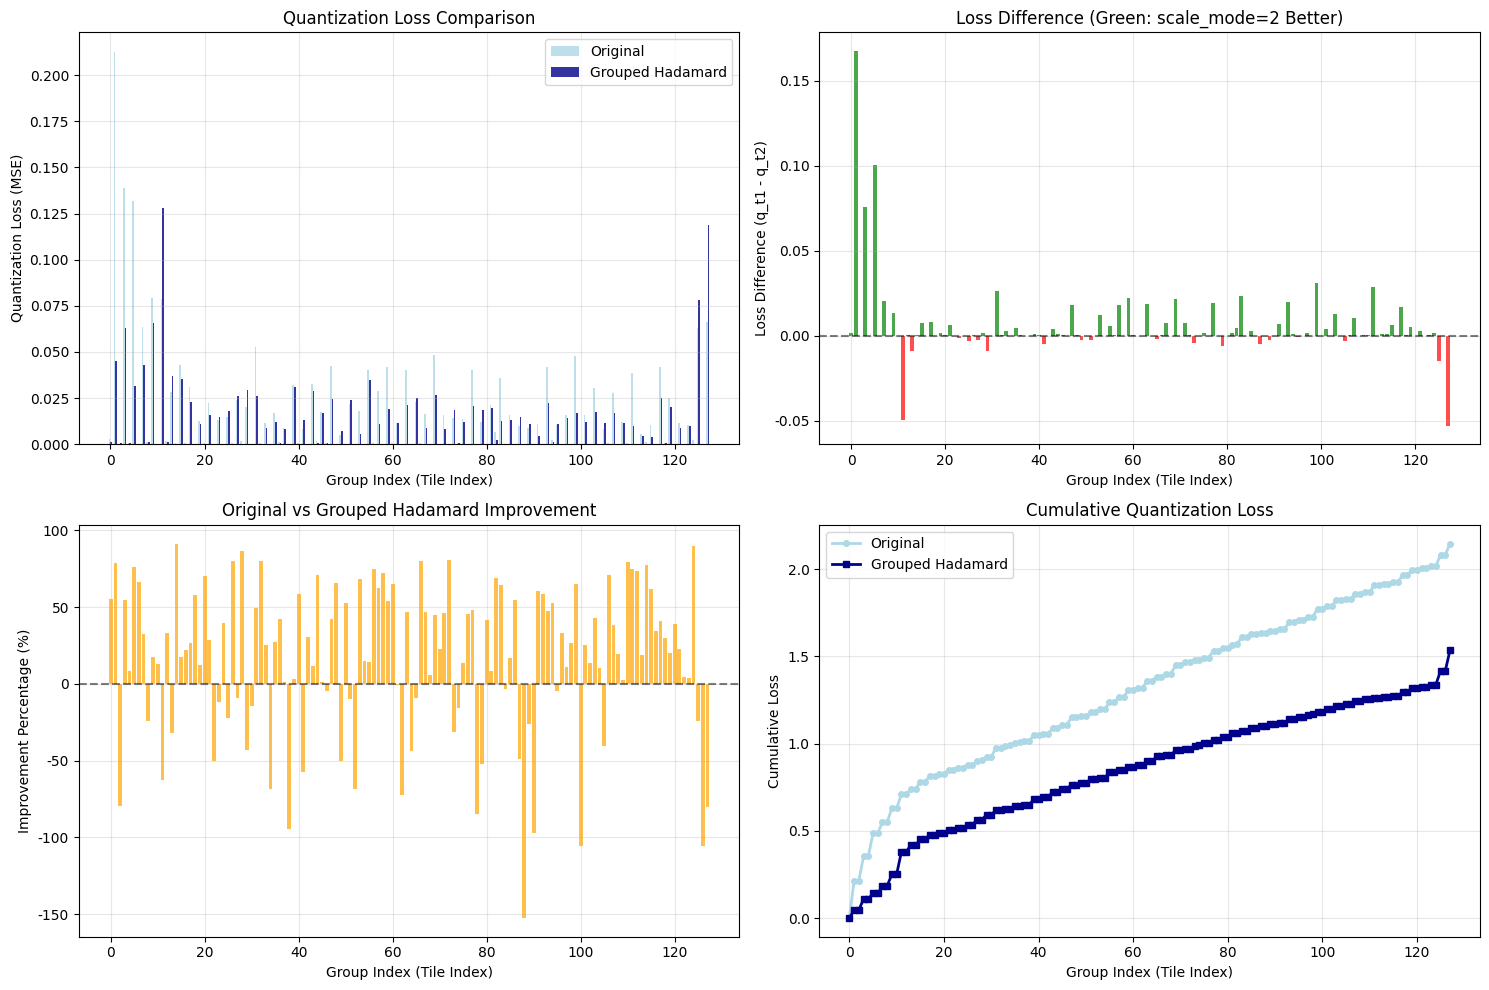

Quantization Loss Statistical Analysis
Metric               Original        Grouped Hadamard Improvement%
------------------------------------------------------------
Average Loss         0.016775        0.011993        17.49     
Total Loss           2.147215        1.535125        28.51     
Max Loss             0.212549        0.127803        91.41     
Min Loss             0.000029        0.000008        -152.51   
Std Dev              0.029202        0.019933       


In [21]:
plot_detailed_quantization_analysis(q_query0_loss, q_roted_query0_loss,
                                    q_t1_label='Original',
                                    q_t2_label='Grouped Hadamard')

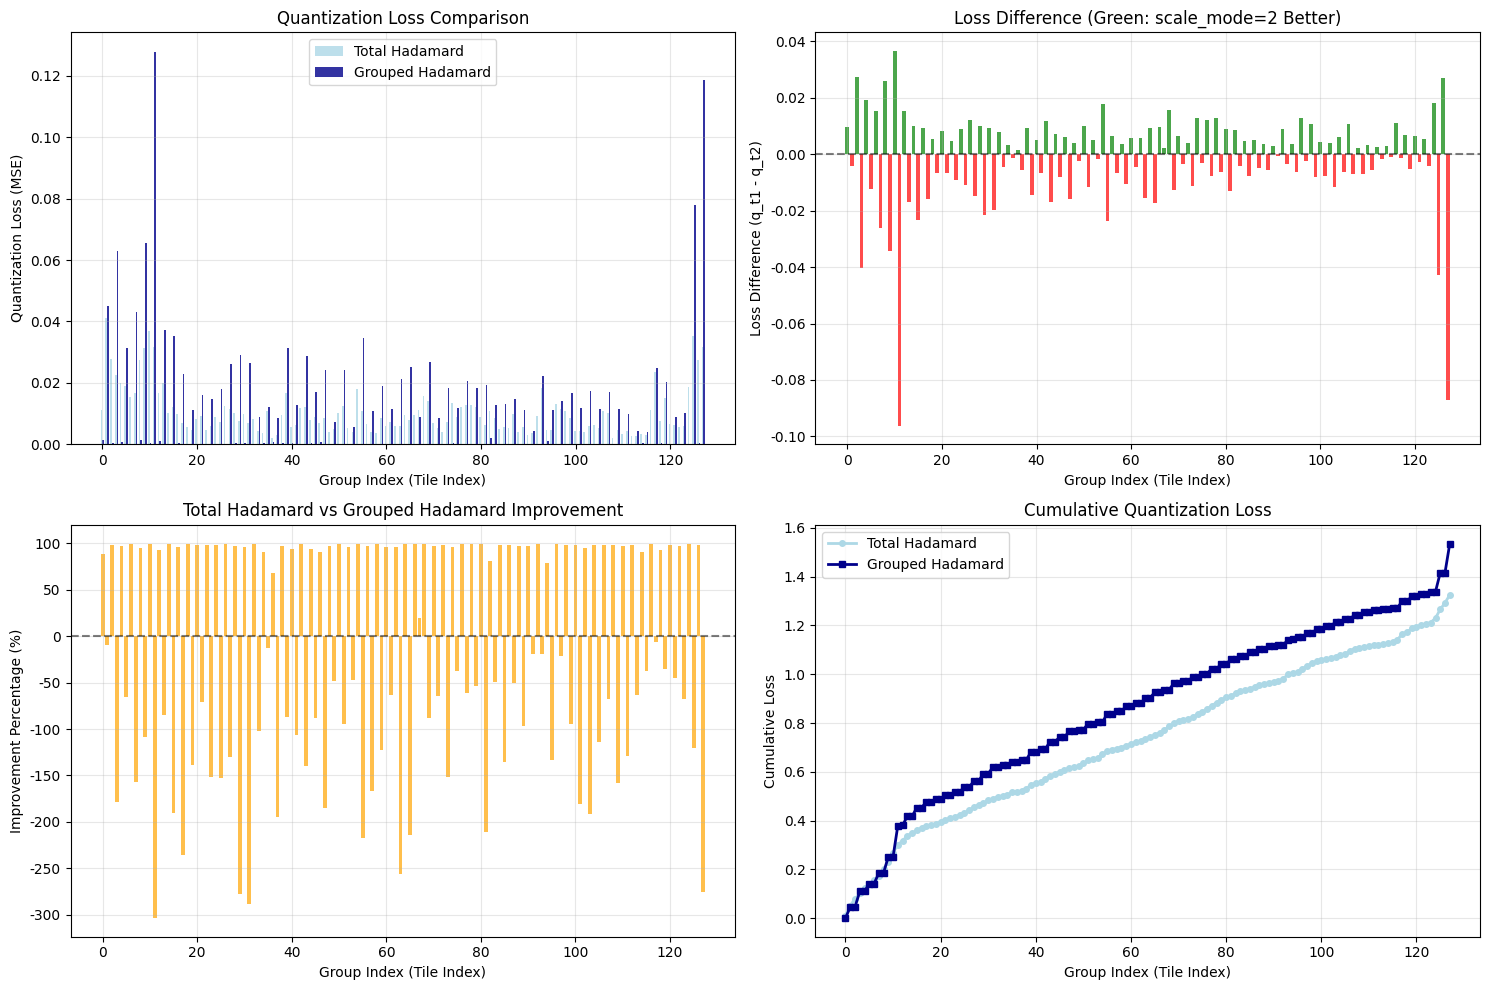

Quantization Loss Statistical Analysis
Metric               Total Hadamard  Grouped Hadamard Improvement%
------------------------------------------------------------
Average Loss         0.010347        0.011993        -9.99     
Total Loss           1.324430        1.535125        -15.91    
Max Loss             0.041089        0.127803        99.82     
Min Loss             0.001992        0.000008        -303.51   
Std Dev              0.007592        0.019933       


In [22]:
plot_detailed_quantization_analysis(q_total_roted_query0_loss, q_roted_query0_loss,
                                    q_t1_label='Total Hadamard',
                                    q_t2_label='Grouped Hadamard')

In [23]:

def analyze_tile_details(original, quantized, tile_index, block_size=32, title_prefix=""):
    """
    分析指定tile的详细量化情况
    
    Args:
        original: 原始张量
        quantized: 量化后的张量
        tile_index: 要分析的tile索引
        block_size: tile大小
        title_prefix: 图表标题前缀
    """
    
    # 转换为numpy
    original_np = original.cpu().numpy() if hasattr(original, 'cpu') else original
    quantized_np = quantized.cpu().numpy() if hasattr(quantized, 'cpu') else quantized
    
    # 计算padding并重塑为tiles
    seq_len = len(original_np)
    num_tiles = (seq_len + block_size - 1) // block_size
    padded_len = num_tiles * block_size
    
    if padded_len > seq_len:
        padding = padded_len - seq_len
        original_padded = np.pad(original_np, (0, padding))
        quantized_padded = np.pad(quantized_np, (0, padding))
    else:
        original_padded = original_np
        quantized_padded = quantized_np
    
    # 重塑为tiles
    original_tiles = original_padded.reshape(-1, block_size)
    quantized_tiles = quantized_padded.reshape(-1, block_size)
    
    # 获取指定tile的数据
    orig_tile = original_tiles[tile_index]
    quant_tile = quantized_tiles[tile_index]
    
    # 计算每个元素的损失
    element_losses = (orig_tile - quant_tile) ** 2
    element_indices = np.arange(block_size)
    
    # 创建详细分析图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 原始值 vs 量化值对比
    axes[0,0].plot(element_indices, orig_tile, 'o-', label='Original', 
                   color='blue', linewidth=2, markersize=4)
    axes[0,0].plot(element_indices, quant_tile, 's-', label='Quantized', 
                   color='red', linewidth=2, markersize=4)
    axes[0,0].set_xlabel('Element Index in Tile')
    axes[0,0].set_ylabel('Value')
    axes[0,0].set_title(f'{title_prefix}Tile {tile_index}: Original vs Quantized')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 每个元素的量化误差
    axes[0,1].bar(element_indices, orig_tile - quant_tile, 
                  color='orange', alpha=0.7)
    axes[0,1].set_xlabel('Element Index in Tile')
    axes[0,1].set_ylabel('Quantization Error (Original - Quantized)')
    axes[0,1].set_title(f'Tile {tile_index}: Quantization Error per Element')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 3. 每个元素的平方误差（MSE贡献）
    colors = ['red' if loss == np.max(element_losses) else 'lightcoral' for loss in element_losses]
    bars = axes[1,0].bar(element_indices, element_losses, color=colors, alpha=0.7)
    axes[1,0].set_xlabel('Element Index in Tile')
    axes[1,0].set_ylabel('Squared Error (MSE Contribution)')
    axes[1,0].set_title(f'Tile {tile_index}: MSE Contribution per Element')
    axes[1,0].grid(True, alpha=0.3)
    
    # 标记最大损失的元素
    max_loss_idx = np.argmax(element_losses)
    axes[1,0].annotate(f'Max Loss\nIndex: {max_loss_idx}\nValue: {element_losses[max_loss_idx]:.6f}',
                       xy=(max_loss_idx, element_losses[max_loss_idx]),
                       xytext=(max_loss_idx + 3, element_losses[max_loss_idx] * 1.2),
                       arrowprops=dict(arrowstyle='->', color='black'),
                       fontsize=10, ha='left')
    
    # 4. 相对误差百分比
    relative_error = np.abs(orig_tile - quant_tile) / (np.abs(orig_tile) + 1e-8) * 100
    axes[1,1].bar(element_indices, relative_error, color='purple', alpha=0.7)
    axes[1,1].set_xlabel('Element Index in Tile')
    axes[1,1].set_ylabel('Relative Error (%)')
    axes[1,1].set_title(f'Tile {tile_index}: Relative Error per Element')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细统计信息
    print("=" * 80)
    print(f"Detailed Analysis for {title_prefix}Tile {tile_index}")
    print("=" * 80)
    print(f"Tile MSE: {np.mean(element_losses):.8f}")
    print(f"Tile Max Squared Error: {np.max(element_losses):.8f} (at index {max_loss_idx})")
    print(f"Tile Min Squared Error: {np.min(element_losses):.8f}")
    print(f"Tile Mean Absolute Error: {np.mean(np.abs(orig_tile - quant_tile)):.8f}")
    print()
    
    # 找出损失最大的几个元素
    top_loss_indices = np.argsort(element_losses)[-5:][::-1]  # 前5个最大损失
    print("Top 5 elements with highest squared error:")
    print(f"{'Index':<8} {'Original':<12} {'Quantized':<12} {'Error':<12} {'Squared Error':<15} {'Rel Error %':<12}")
    print("-" * 80)
    for idx in top_loss_indices:
        orig_val = orig_tile[idx]
        quant_val = quant_tile[idx]
        error = orig_val - quant_val
        sq_error = element_losses[idx]
        rel_error = np.abs(error) / (np.abs(orig_val) + 1e-8) * 100
        print(f"{idx:<8} {orig_val:<12.6f} {quant_val:<12.6f} {error:<12.6f} {sq_error:<15.8f} {rel_error:<12.2f}")


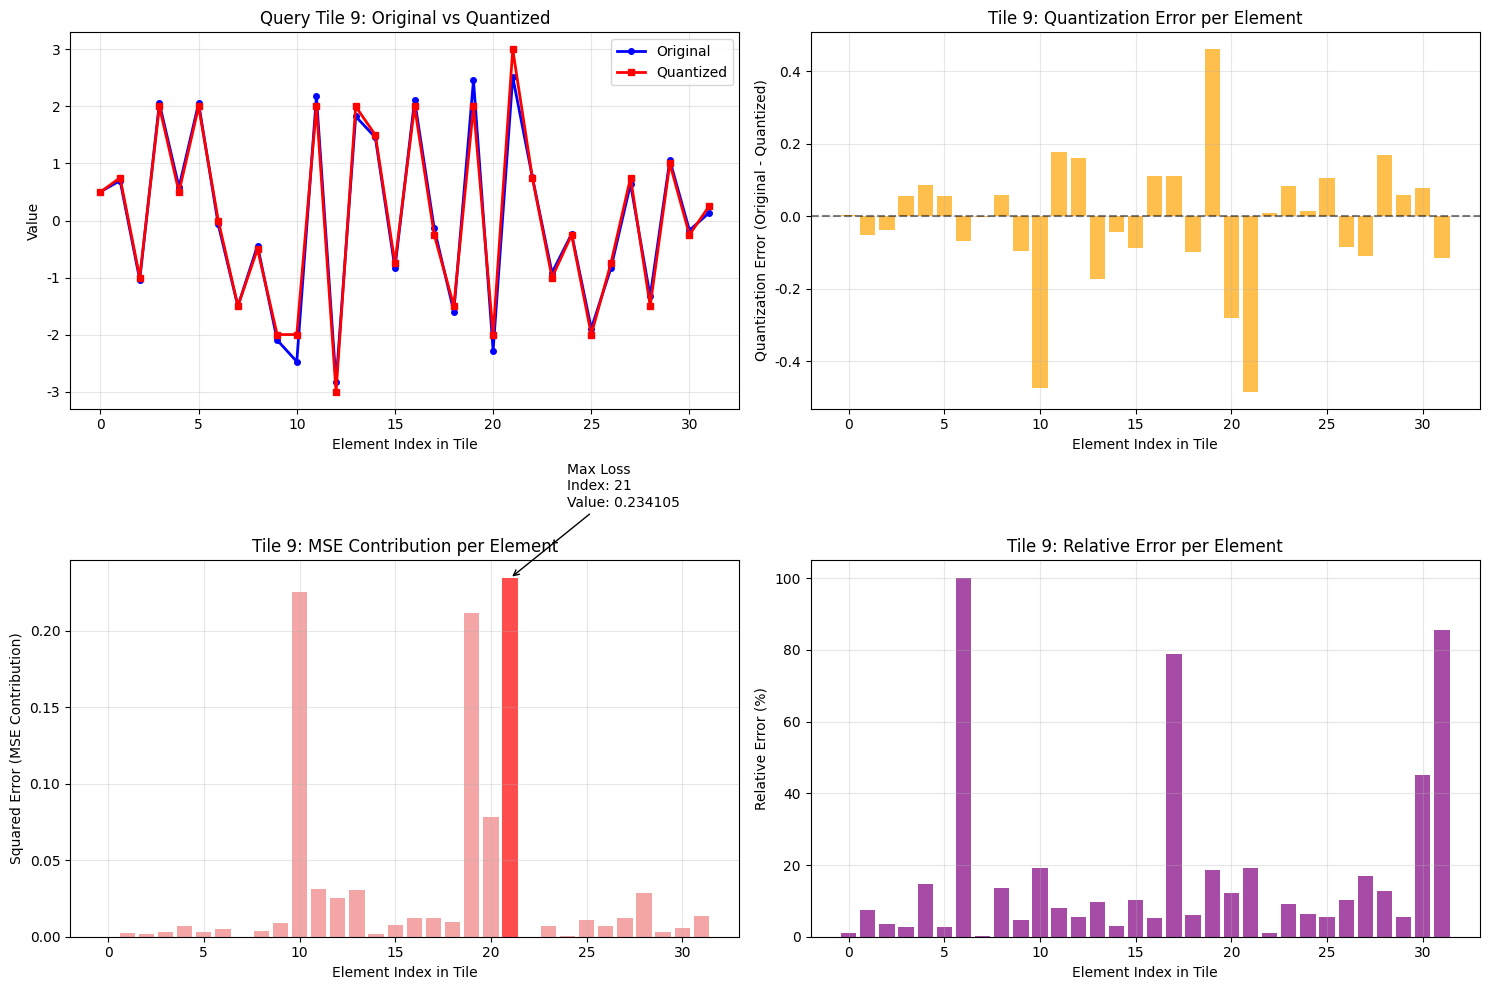

Detailed Analysis for Query Tile 9
Tile MSE: 0.03135496
Tile Max Squared Error: 0.23410459 (at index 21)
Tile Min Squared Error: 0.00000643
Tile Mean Absolute Error: 0.12500644

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
21       2.516156     3.000000     -0.483844    0.23410459      19.23       
10       -2.474625    -2.000000    -0.474625    0.22526877      19.18       
19       2.459941     2.000000     0.459941     0.21154565      18.70       
20       -2.279763    -2.000000    -0.279763    0.07826719      12.27       
11       2.176526     2.000000     0.176526     0.03116154      8.11        


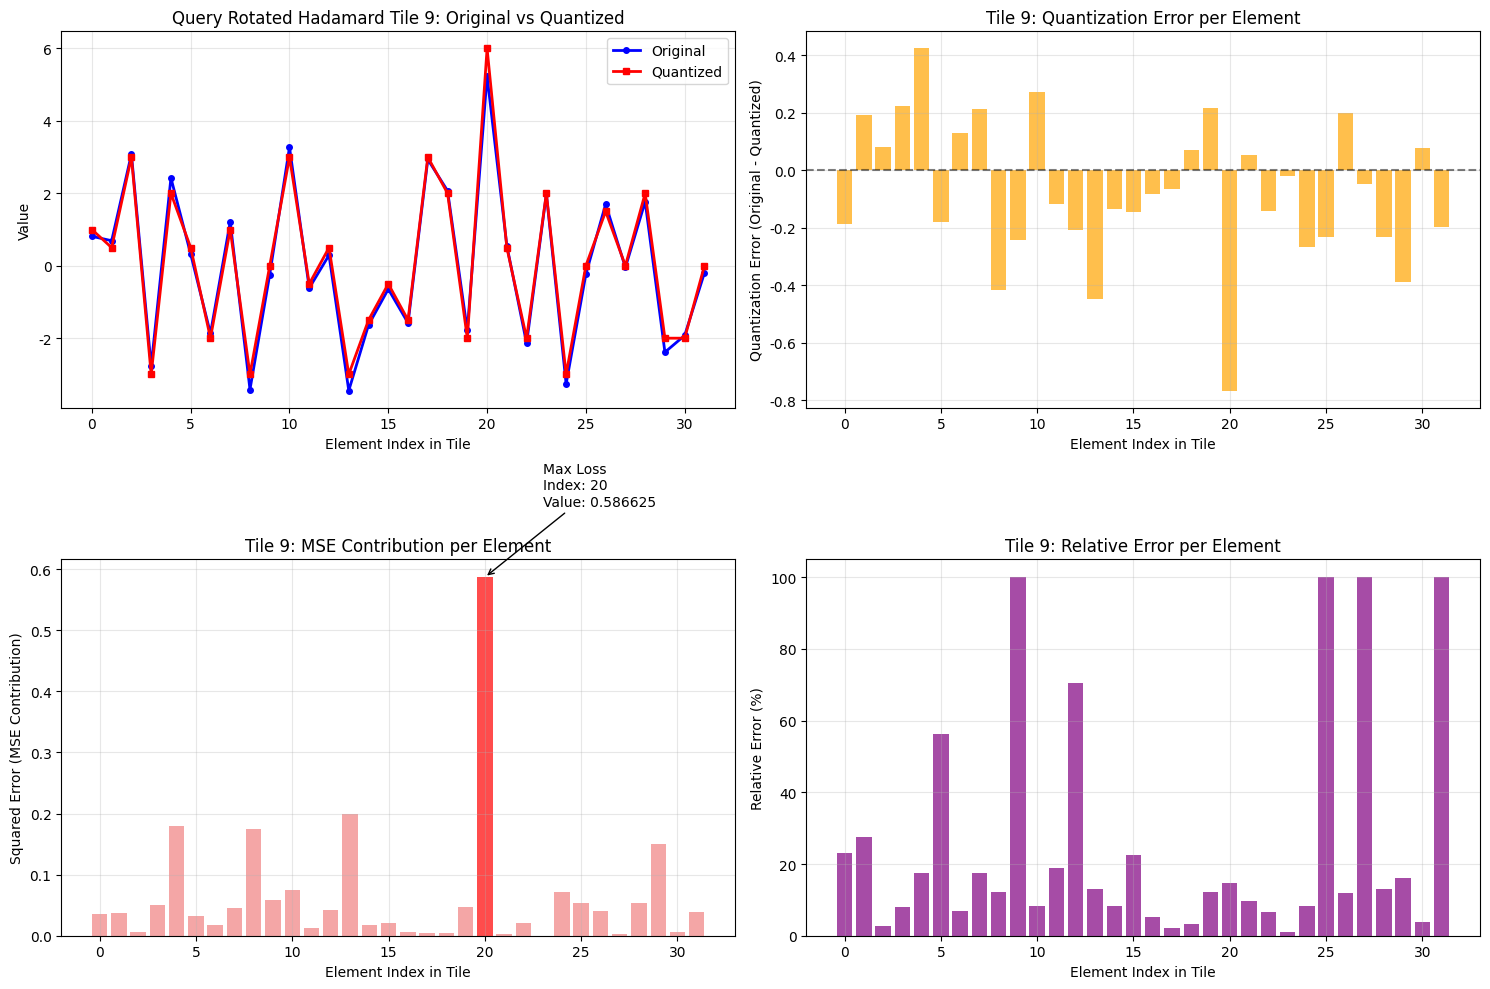

Detailed Analysis for Query Rotated Hadamard Tile 9
Tile MSE: 0.06547108
Tile Max Squared Error: 0.58662492 (at index 20)
Tile Min Squared Error: 0.00035767
Tile Mean Absolute Error: 0.20839547

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
20       5.234086     6.000000     -0.765914    0.58662492      14.63       
13       -3.446940    -3.000000    -0.446940    0.19975574      12.97       
4        2.423785     2.000000     0.423785     0.17959370      17.48       
8        -3.417679    -3.000000    -0.417679    0.17445581      12.22       
29       -2.387489    -2.000000    -0.387489    0.15014760      16.23       


In [24]:
analyze_tile_details(total_roted_query0, q_total_roted_query0, tile_index=9, block_size=32, title_prefix="Query ")
analyze_tile_details(query0_roted, q_roted_query0, tile_index=9, block_size=32, title_prefix="Query Rotated Hadamard ")

In [25]:
query0_reshaped = query0.reshape(32, 128).reshape(8, 4, 128).mean(dim=1)
sorting_index = torch.argsort(query0_reshaped.abs(), dim=-1, descending=True)
query0_reshaped = torch.gather(query0_reshaped, dim=-1, index=sorting_index)

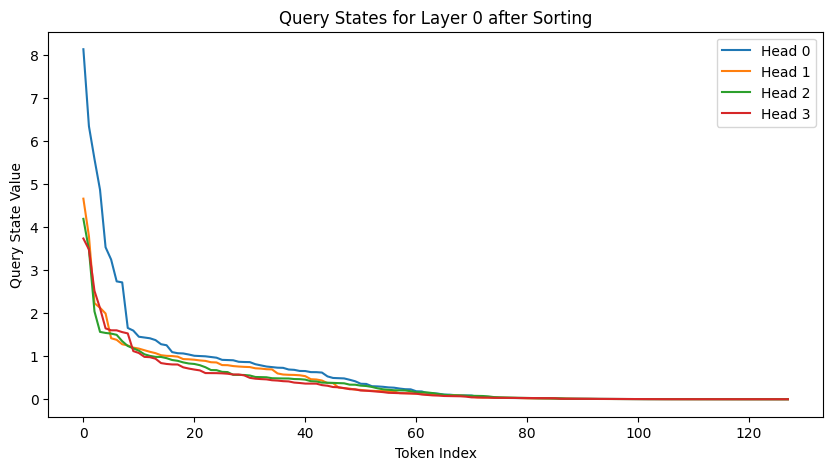

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(query0_reshaped[0].cpu().float().abs().numpy(), label='Head 0')
plt.plot(query0_reshaped[1].cpu().float().abs().numpy(), label='Head 1')
plt.plot(query0_reshaped[2].cpu().float().abs().numpy(), label='Head 2')
plt.plot(query0_reshaped[3].cpu().float().abs().numpy(), label='Head 3')
plt.title('Query States for Layer 0 after Sorting')
plt.xlabel('Token Index')
plt.ylabel('Query State Value')
plt.legend()
plt.show()

In [27]:
query0_reshaped = query0.reshape(8, 4, 128)
sorting_index_expanded = sorting_index.unsqueeze(1).expand(8, 4, 128)
query0_sorted = torch.gather(query0_reshaped, dim=-1, index=sorting_index_expanded)

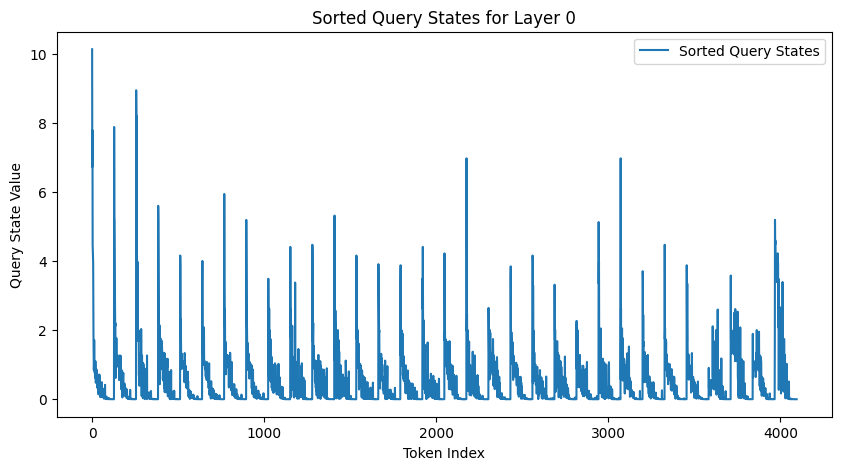

In [28]:
query0_sorted = query0_sorted.reshape(-1)
plt.figure(figsize=(10, 5))
plt.plot(query0_sorted.cpu().float().abs().numpy(), label='Sorted Query States')
plt.title('Sorted Query States for Layer 0')
plt.xlabel('Token Index')
plt.ylabel('Query State Value')
plt.legend()
plt.show()

In [29]:
q_query0_sorted = quantize_mx_op(query0_sorted,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
q_query0_sorted_loss = compute_tile_quantization_loss(query0_sorted, q_query0_sorted, block_size=32, loss_type='mse')
                      

In [30]:
roted_query0_sorted = hadamard_transform(query0_sorted.reshape(-1, query0_sorted.shape[0] // 32,
                                                      32), scale=1 / math.sqrt(32)).reshape(-1)
q_roted_query0_sorted = quantize_mx_op(roted_query0_sorted,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
q_roted_query0_sorted_loss = compute_tile_quantization_loss(roted_query0_sorted, q_roted_query0_sorted, block_size=32, loss_type='mse')

In [31]:
total_roted_query0_sorted = hadamard_transform(query0_sorted.reshape(-1, query0_sorted.shape[0] // 128,
                                                      128), scale=1 / math.sqrt(128)).reshape(-1)
q_total_roted_query0_sorted = quantize_mx_op(total_roted_query0_sorted,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
q_total_roted_query0_sorted_loss = compute_tile_quantization_loss(total_roted_query0_sorted, q_total_roted_query0_sorted, block_size=32, loss_type='mse')

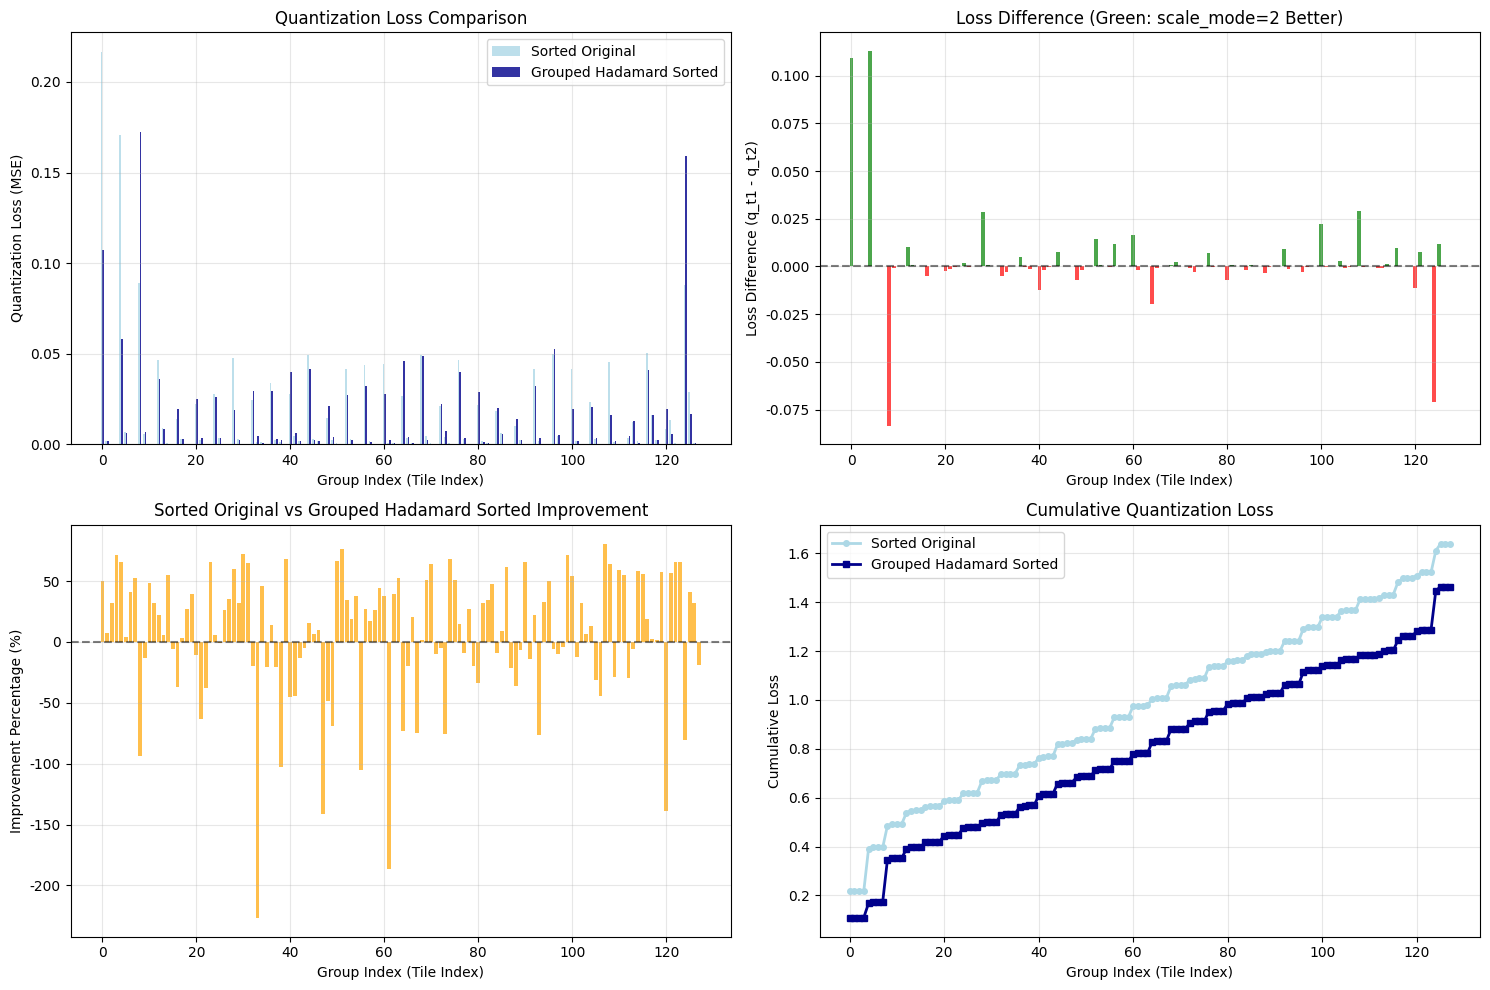

Quantization Loss Statistical Analysis
Metric               Sorted Original Grouped Hadamard Sorted Improvement%
------------------------------------------------------------
Average Loss         0.012812        0.011438        7.04      
Total Loss           1.639941        1.464114        10.72     
Max Loss             0.216570        0.172127        80.89     
Min Loss             0.000000        0.000000        -226.79   
Std Dev              0.028913        0.025096       


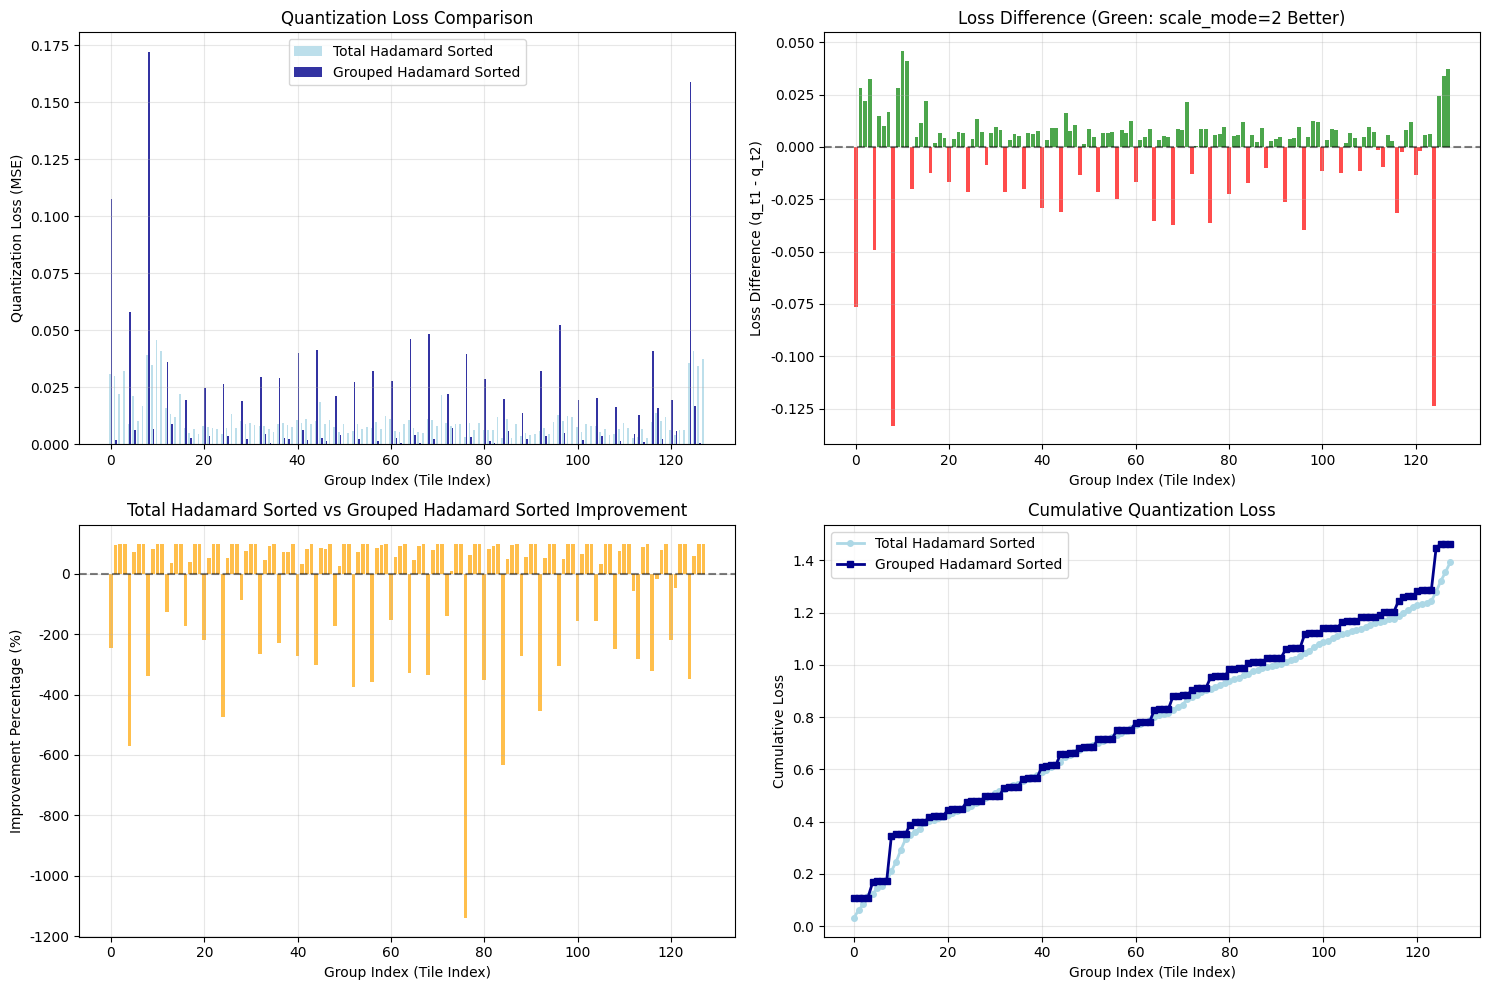

Quantization Loss Statistical Analysis
Metric               Total Hadamard Sorted Grouped Hadamard Sorted Improvement%
------------------------------------------------------------
Average Loss         0.010876        0.011438        -17.66    
Total Loss           1.392160        1.464114        -5.17     
Max Loss             0.045820        0.172127        100.00    
Min Loss             0.002538        0.000000        -1139.92  
Std Dev              0.008781        0.025096       


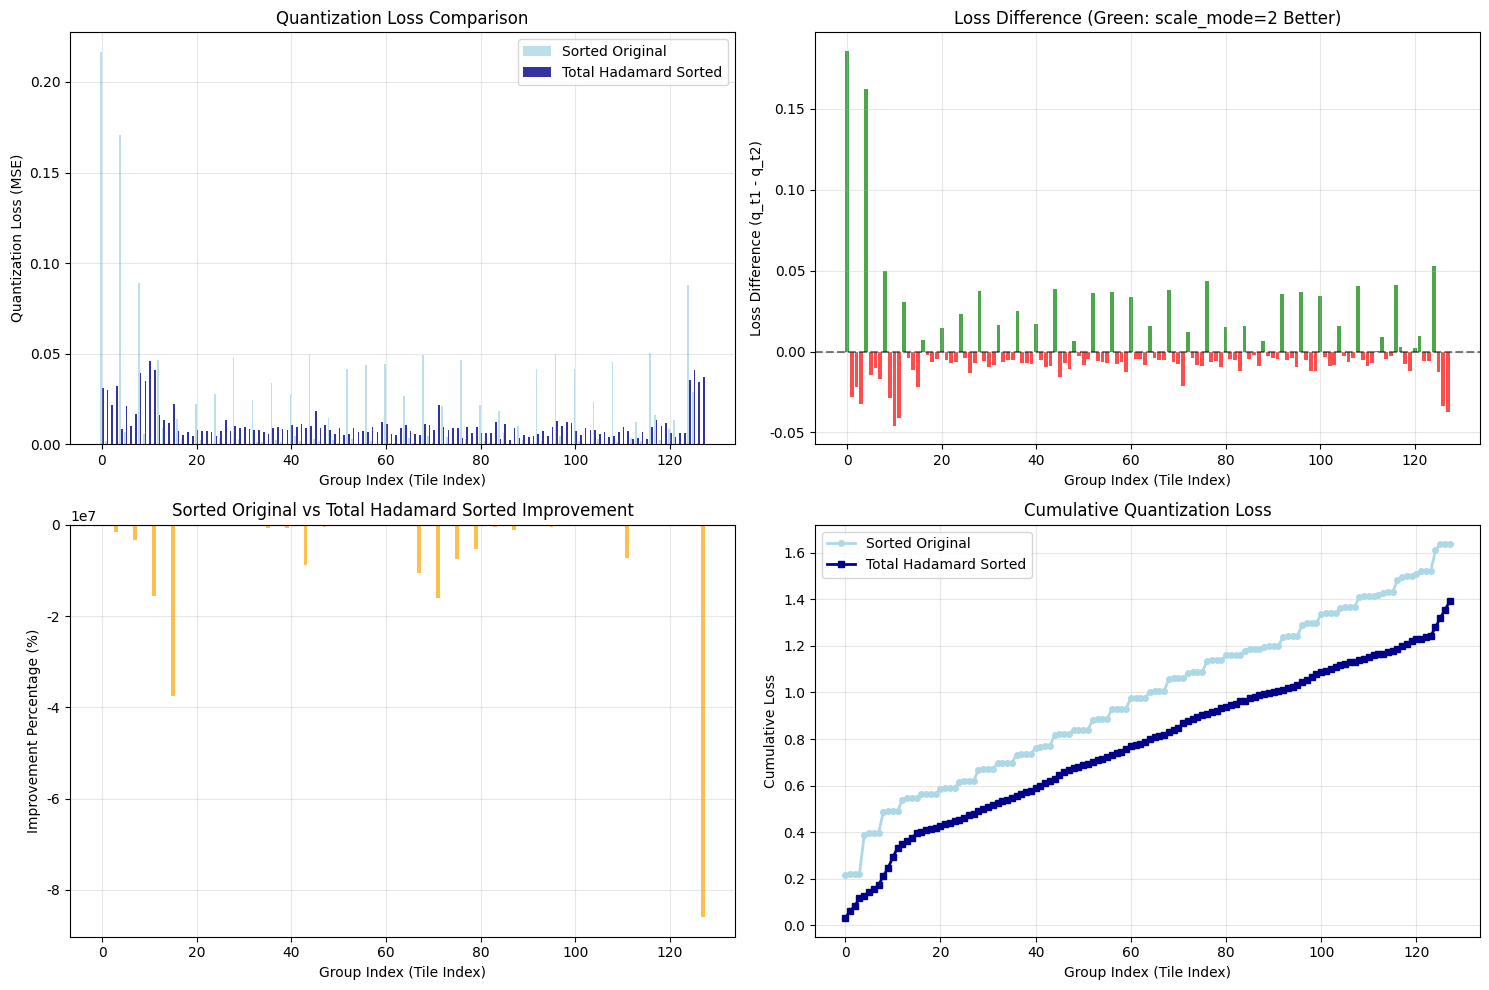

Quantization Loss Statistical Analysis
Metric               Sorted Original Total Hadamard Sorted Improvement%
------------------------------------------------------------
Average Loss         0.012812        0.010876        -1599094.00
Total Loss           1.639941        1.392160        15.11     
Max Loss             0.216570        0.045820        94.92     
Min Loss             0.000000        0.002538        -85949296.00
Std Dev              0.028913        0.008781       


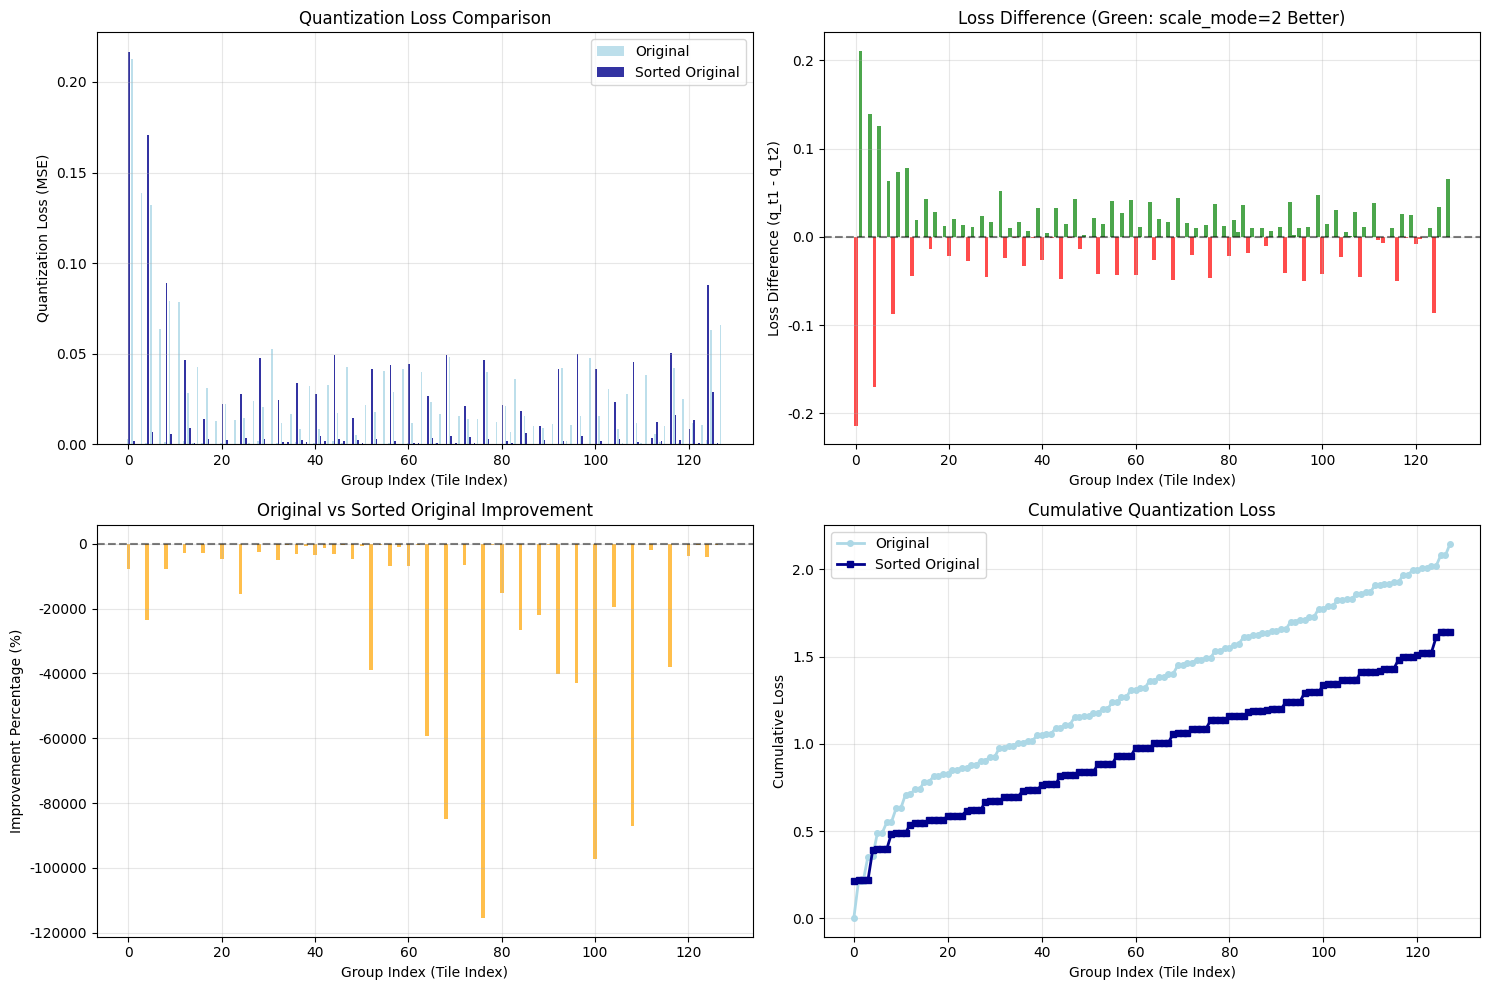

Quantization Loss Statistical Analysis
Metric               Original        Sorted Original Improvement%
------------------------------------------------------------
Average Loss         0.016775        0.012812        -6275.32  
Total Loss           2.147215        1.639941        23.62     
Max Loss             0.212549        0.216570        100.00    
Min Loss             0.000029        0.000000        -115488.09
Std Dev              0.029202        0.028913       


In [32]:
plot_detailed_quantization_analysis(q_query0_sorted_loss, q_roted_query0_sorted_loss,
                                    q_t1_label='Sorted Original',
                                    q_t2_label='Grouped Hadamard Sorted')
plot_detailed_quantization_analysis(q_total_roted_query0_sorted_loss, q_roted_query0_sorted_loss,
                                    q_t1_label='Total Hadamard Sorted',
                                    q_t2_label='Grouped Hadamard Sorted')
plot_detailed_quantization_analysis(q_query0_sorted_loss, q_total_roted_query0_sorted_loss,
                                    q_t1_label='Sorted Original',
                                    q_t2_label='Total Hadamard Sorted')
plot_detailed_quantization_analysis(q_query0_loss, q_query0_sorted_loss,
                                    q_t1_label='Original',
                                    q_t2_label='Sorted Original')

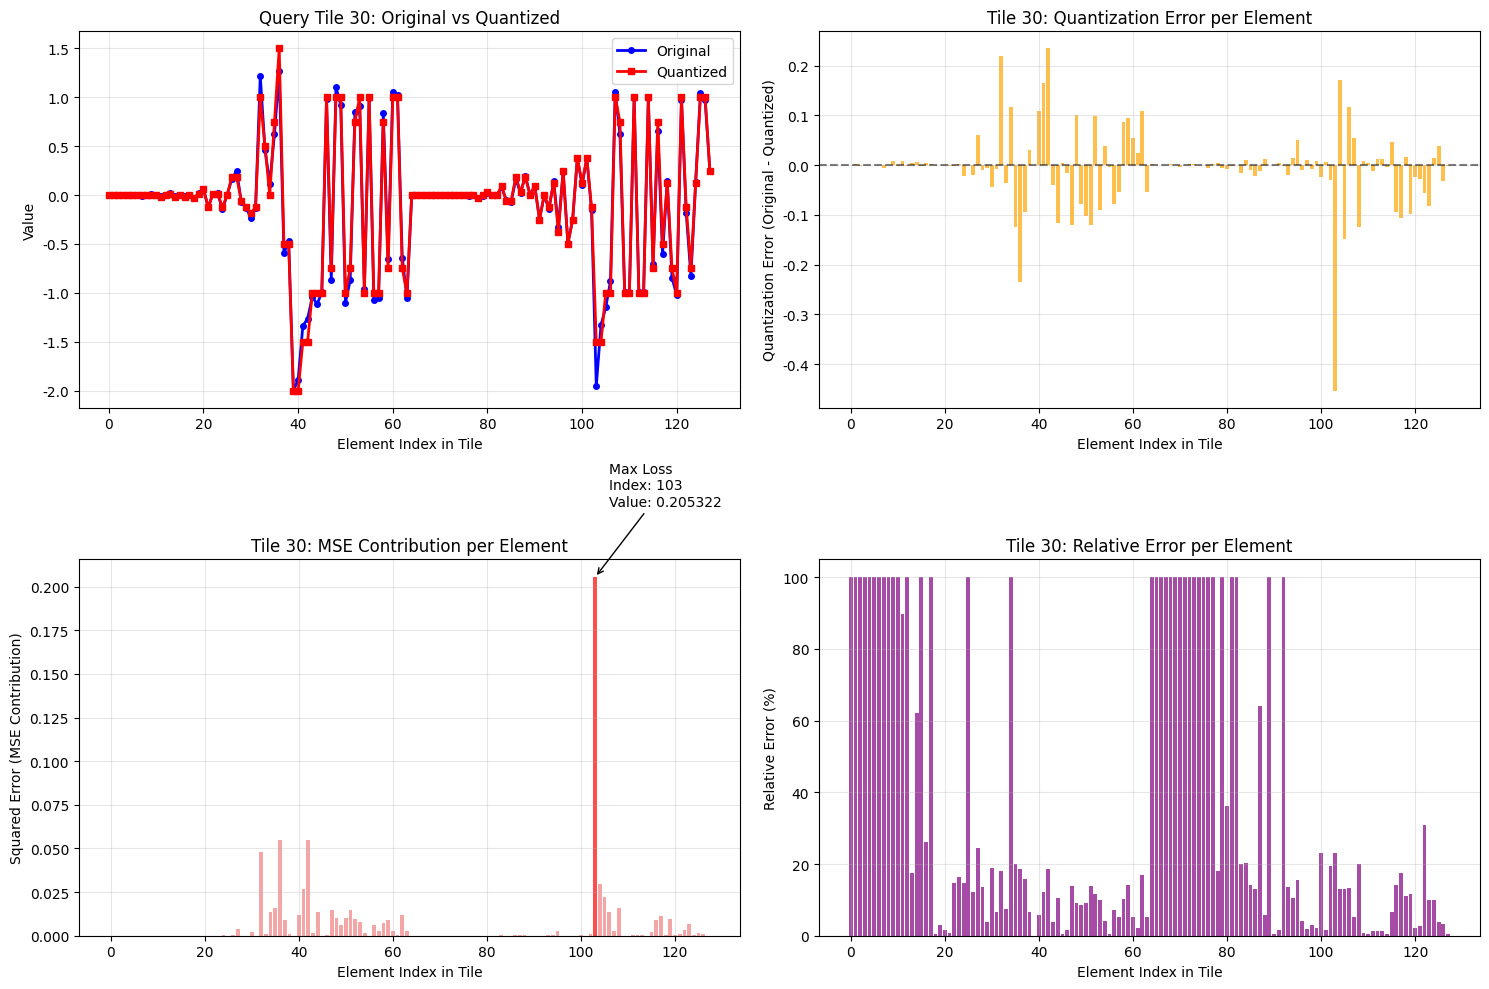

Detailed Analysis for Query Tile 30
Tile MSE: 0.00562523
Tile Max Squared Error: 0.20532227 (at index 103)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.04016656

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
103      -1.953125    -1.500000    -0.453125    0.20532227      23.20       
36       1.265625     1.500000     -0.234375    0.05493164      18.52       
42       -1.265625    -1.500000    0.234375     0.05493164      18.52       
32       1.218750     1.000000     0.218750     0.04785156      17.95       
104      -1.328125    -1.500000    0.171875     0.02954102      12.94       


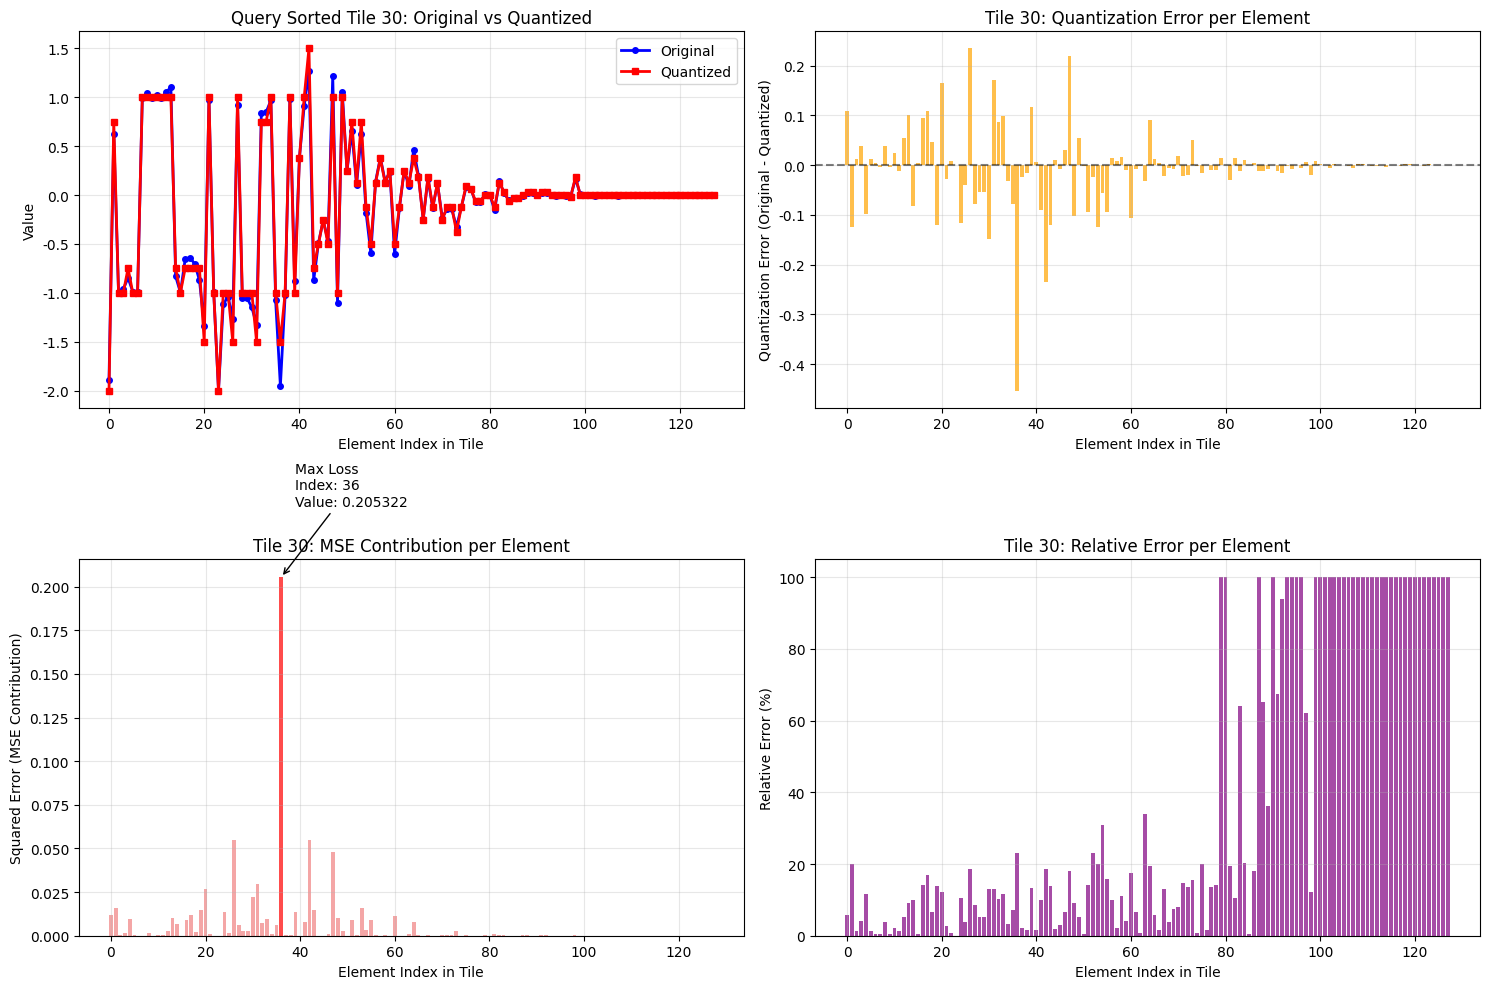

Detailed Analysis for Query Sorted Tile 30
Tile MSE: 0.00554728
Tile Max Squared Error: 0.20532227 (at index 36)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.03977078

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
36       -1.953125    -1.500000    -0.453125    0.20532227      23.20       
42       1.265625     1.500000     -0.234375    0.05493164      18.52       
26       -1.265625    -1.500000    0.234375     0.05493164      18.52       
47       1.218750     1.000000     0.218750     0.04785156      17.95       
31       -1.328125    -1.500000    0.171875     0.02954102      12.94       


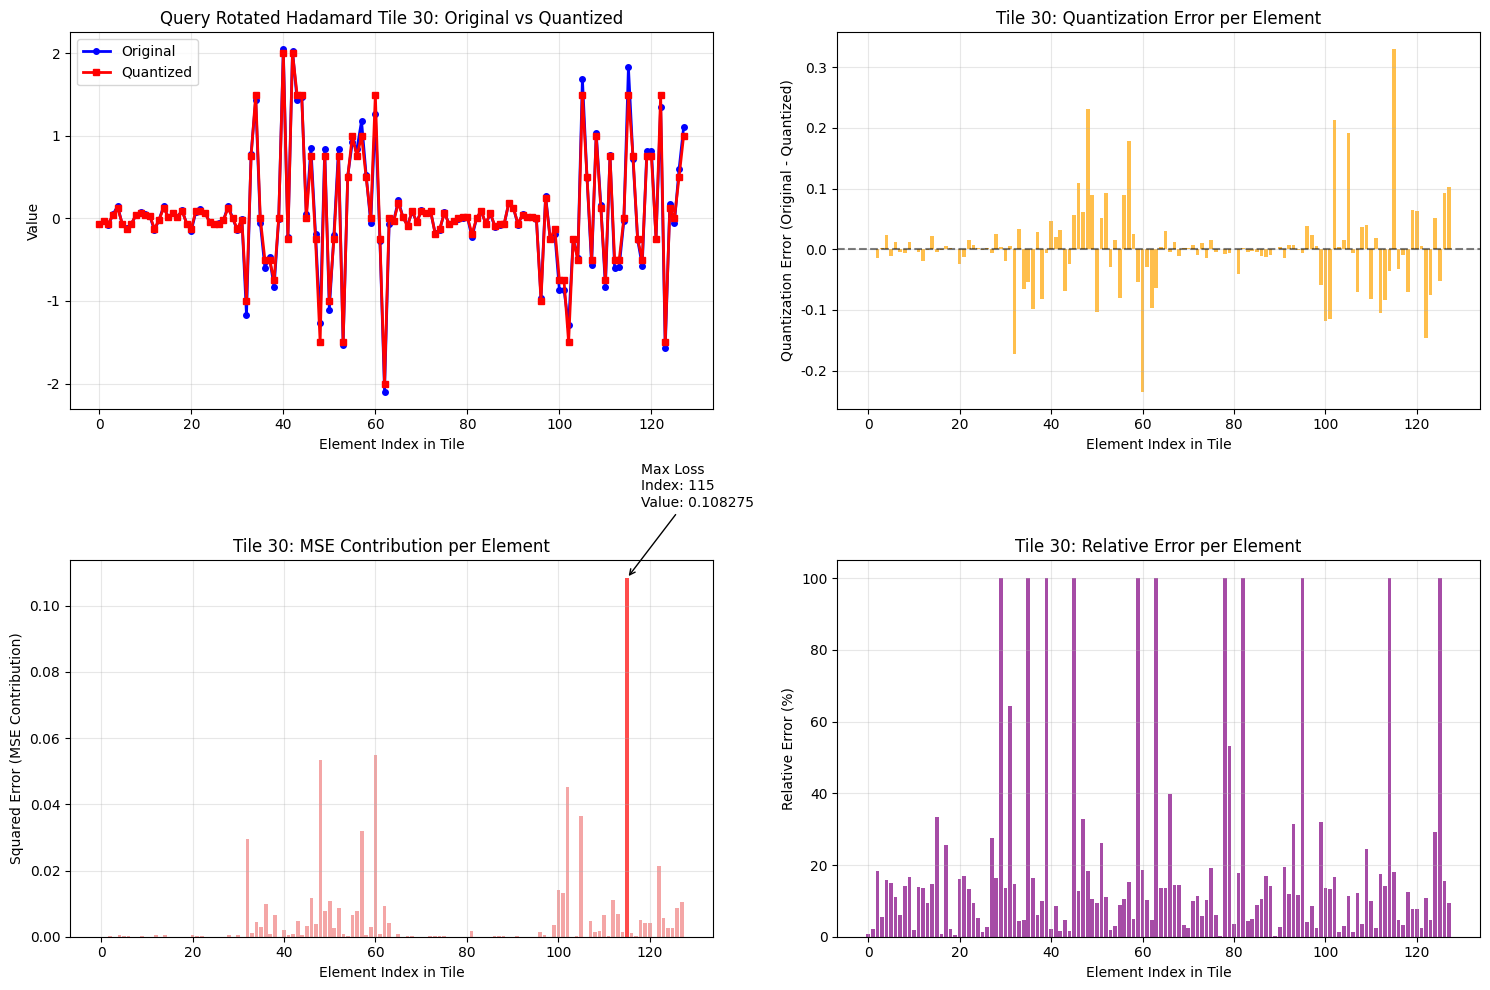

Detailed Analysis for Query Rotated Hadamard Tile 30
Tile MSE: 0.00483243
Tile Max Squared Error: 0.10827512 (at index 115)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.04152642

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
115      1.829052     1.500000     0.329052     0.10827512      17.99       
60       1.265576     1.500000     -0.234424    0.05495455      18.52       
48       -1.268684    -1.500000    0.231316     0.05350730      18.23       
102      -1.286983    -1.500000    0.213017     0.04537639      16.55       
105      1.691290     1.500000     0.191290     0.03659196      11.31       


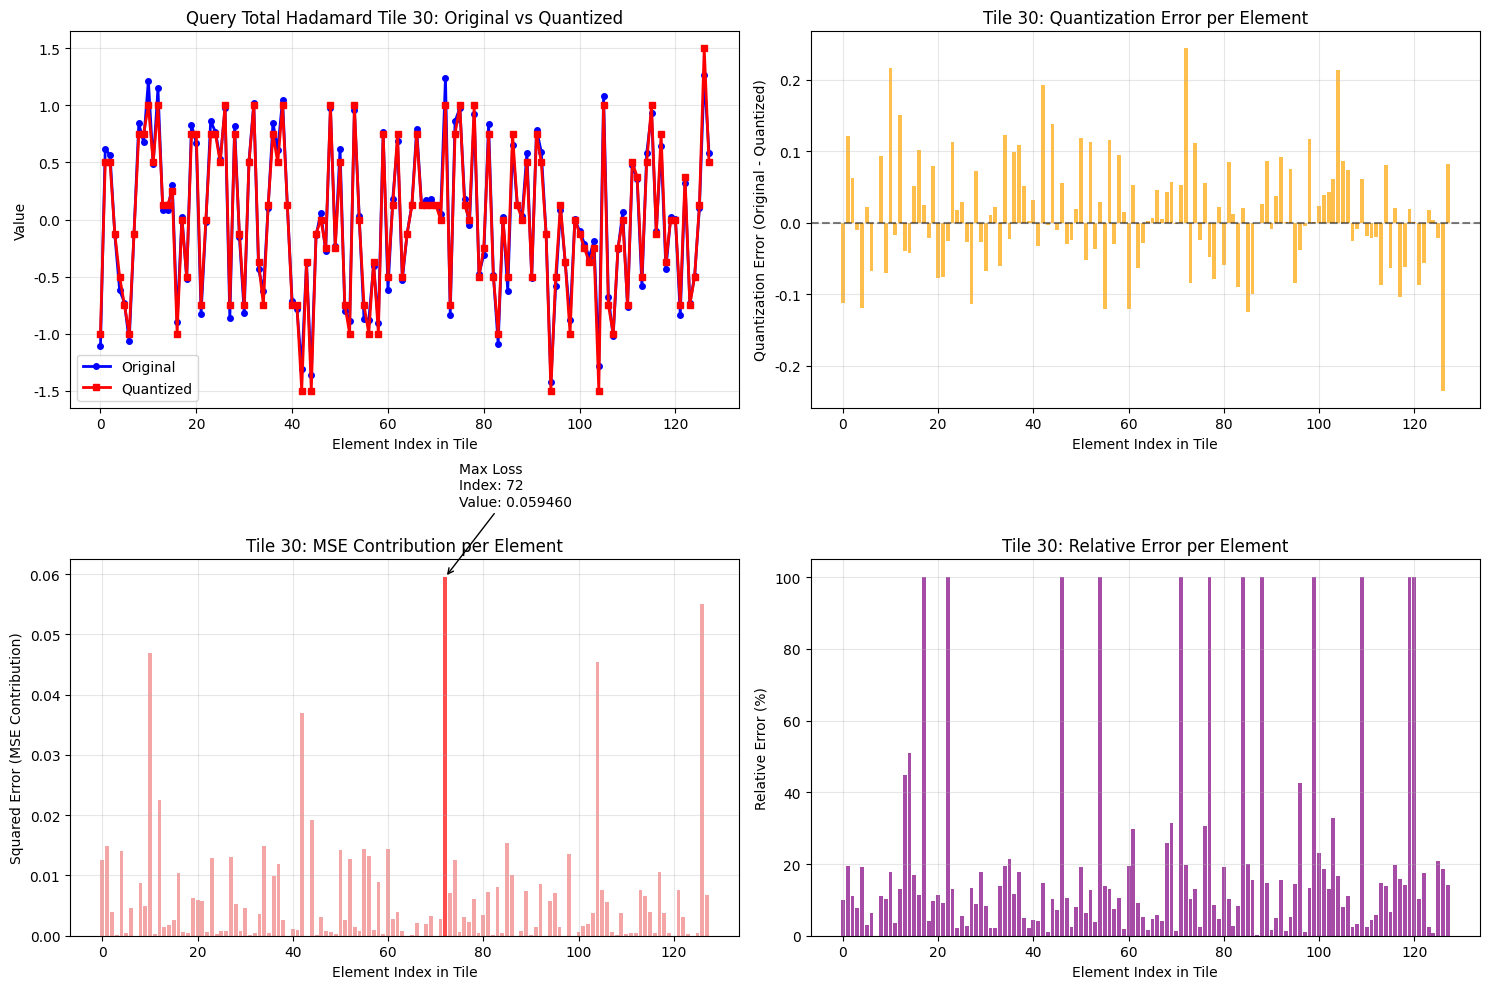

Detailed Analysis for Query Total Hadamard Tile 30
Tile MSE: 0.00607526
Tile Max Squared Error: 0.05946014 (at index 72)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.05994229

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
72       1.243845     1.000000     0.243845     0.05946014      19.60       
126      1.265543     1.500000     -0.234457    0.05497015      18.53       
10       1.216435     1.000000     0.216435     0.04684419      17.79       
104      -1.286962    -1.500000    0.213038     0.04538502      16.55       
42       -1.307812    -1.500000    0.192188     0.03693637      14.70       


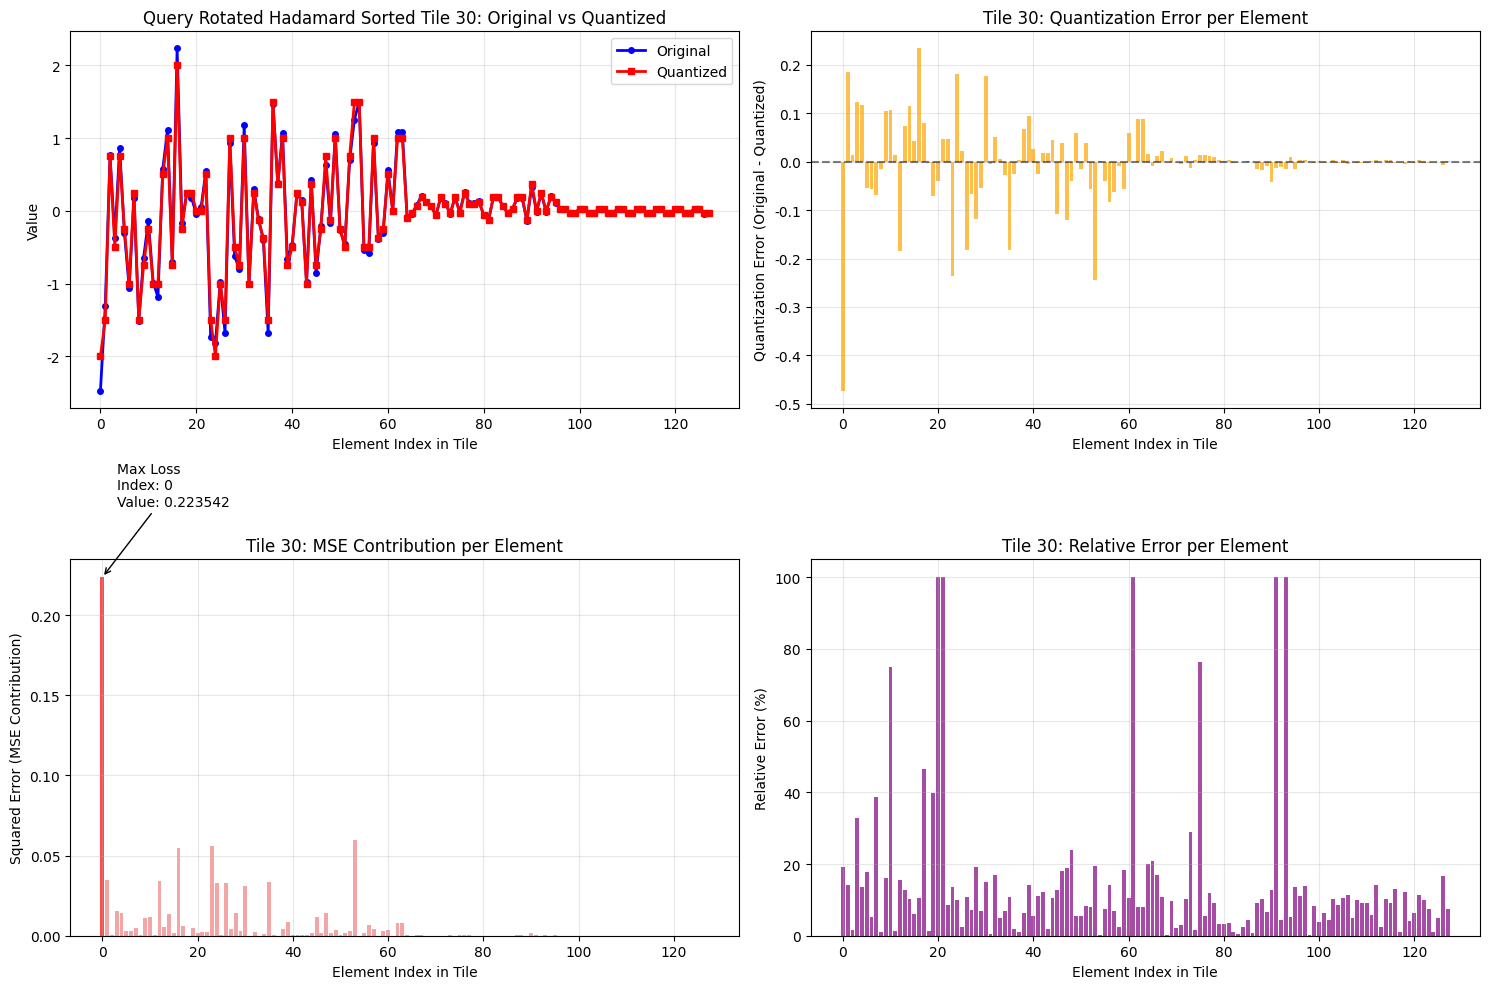

Detailed Analysis for Query Rotated Hadamard Sorted Tile 30
Tile MSE: 0.00636252
Tile Max Squared Error: 0.22354189 (at index 0)
Tile Min Squared Error: 0.00000001
Tile Mean Absolute Error: 0.04295173

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
0        -2.472802    -2.000000    -0.472802    0.22354189      19.12       
53       1.255995     1.500000     -0.244005    0.05953848      19.43       
23       -1.736693    -1.500000    -0.236693    0.05602353      13.63       
16       2.233877     2.000000     0.233877     0.05469865      10.47       
1        -1.314086    -1.500000    0.185914     0.03456398      14.15       


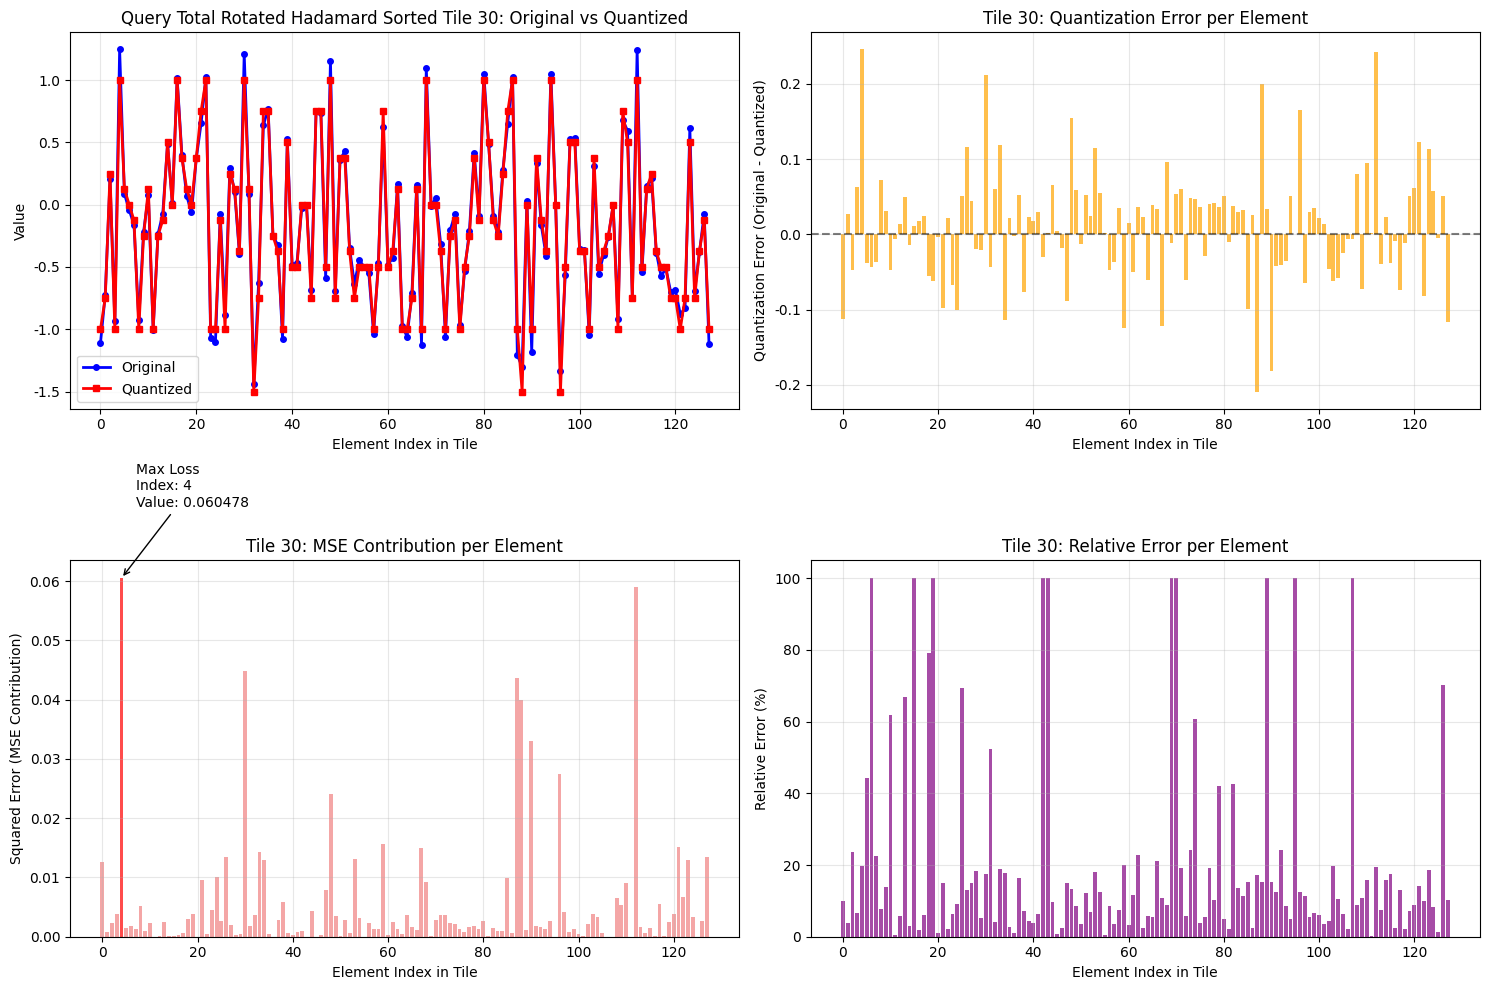

Detailed Analysis for Query Total Rotated Hadamard Sorted Tile 30
Tile MSE: 0.00554589
Tile Max Squared Error: 0.06047802 (at index 4)
Tile Min Squared Error: 0.00000109
Tile Mean Absolute Error: 0.05602569

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
4        1.245923     1.000000     0.245923     0.06047802      19.74       
112      1.242840     1.000000     0.242840     0.05897141      19.54       
30       1.211846     1.000000     0.211846     0.04487872      17.48       
87       -1.208917    -1.000000    -0.208917    0.04364637      17.28       
88       -1.300062    -1.500000    0.199938     0.03997508      15.38       


In [37]:
idx = 30
analyze_tile_details(query0, q_query0, tile_index=idx, block_size=128, title_prefix="Query ")
analyze_tile_details(query0_sorted, q_query0_sorted, tile_index=idx, block_size=128, title_prefix="Query Sorted ")
analyze_tile_details(query0_roted, q_roted_query0, tile_index=idx, block_size=128, title_prefix="Query Rotated Hadamard ")
analyze_tile_details(total_roted_query0, q_total_roted_query0, tile_index=idx, block_size=128, title_prefix="Query Total Hadamard ")
analyze_tile_details(roted_query0_sorted, q_roted_query0_sorted, tile_index=idx, block_size=128, title_prefix="Query Rotated Hadamard Sorted ")
analyze_tile_details(total_roted_query0_sorted, q_total_roted_query0_sorted, tile_index=idx, block_size=128, title_prefix="Query Total Rotated Hadamard Sorted ")